# Analyze Sandpiles
This notebooks contains all analyses done on the generated avalanche data.

In [1]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import glob, os
import lmfit

# Pretty matplotlib plots
plt.rcParams.update(
    {
        "figure.dpi": 300,
        "font.family": "serif",
        "font.serif": "cm",
        "mathtext.fontset": "cm",
        # INFO: Enable this, in case you want latex rendering
        # "text.usetex": True,
        "axes.grid": True,
        "grid.linewidth": 0.2,
        "grid.alpha": 0.5,
    }
)

# define colors for later use
d_colors = {2: "forestgreen", 3: "darkorange", 4: "crimson"}
N_colors = {6: plt.cm.viridis(0), 12: plt.cm.viridis(.5), 18: plt.cm.viridis(.9)}

In [2]:
def load_avalanches(d, N, closed=False, cons=False):
    """
    Loads the avalanches for a given d, N, and closed/cons options,
    which were generated by `generate_sandpiles.ipynb`.
    """
    if cons and closed:
        dir_path = f"avalanches_cons/d{d}"
    elif cons:
        dir_path = f"avalanches_cons_closed/d{d}"
    elif closed:
        dir_path = f"avalanches_closed/d{d}"
    else:
        dir_path = f"avalanches/d{d}"

    try:
        return pd.read_feather(f"{dir_path}/N{N}.feather")
    except FileNotFoundError:
        return None

d_vals = [2, 3, 4]

def get_avalanche_N_vals(d, closed=False, cons=False):
    """
    Searches the avalanche directory for avalanches for a given d,
    and returns the available N values.
    """
    if cons and closed:
        dir_path = f"avalanches_cons/d{d}"
    elif cons:
        dir_path = f"avalanches_cons_closed/d{d}"
    elif closed:
        dir_path = f"avalanches_closed/d{d}"
    else:
        dir_path = f"avalanches/d{d}"

    files = glob.glob(f"{dir_path}/*.feather")
    N_vals = [int(os.path.splitext(os.path.basename(f))[0][1:]) for f in files]
    N_vals.sort()
    return N_vals

def load_all_avalanches(d, closed=False, cons=False):
    """
    Loads all avalanches for a given d, and returns a list of dataframes
    and the list of the corresponding N values.
    """
    N_vals = get_avalanche_N_vals(d, closed=closed, cons=cons)
    avalanches_dfs = [load_avalanches(d, N, closed=closed, cons=cons) for N in N_vals]
    return avalanches_dfs, N_vals

In [3]:
def plot_z_avg(d, N):
    """Plots the slope lattice for a given d, N."""
    df = load_avalanches(d, N)
    plt.plot(df.index, df["z_avg"], '.k', ms=1)
    plt.xlabel("step")
    plt.ylabel("$\\langle z \\rangle$")
    plt.show()

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'serif' not found because none of the following families were found: cm


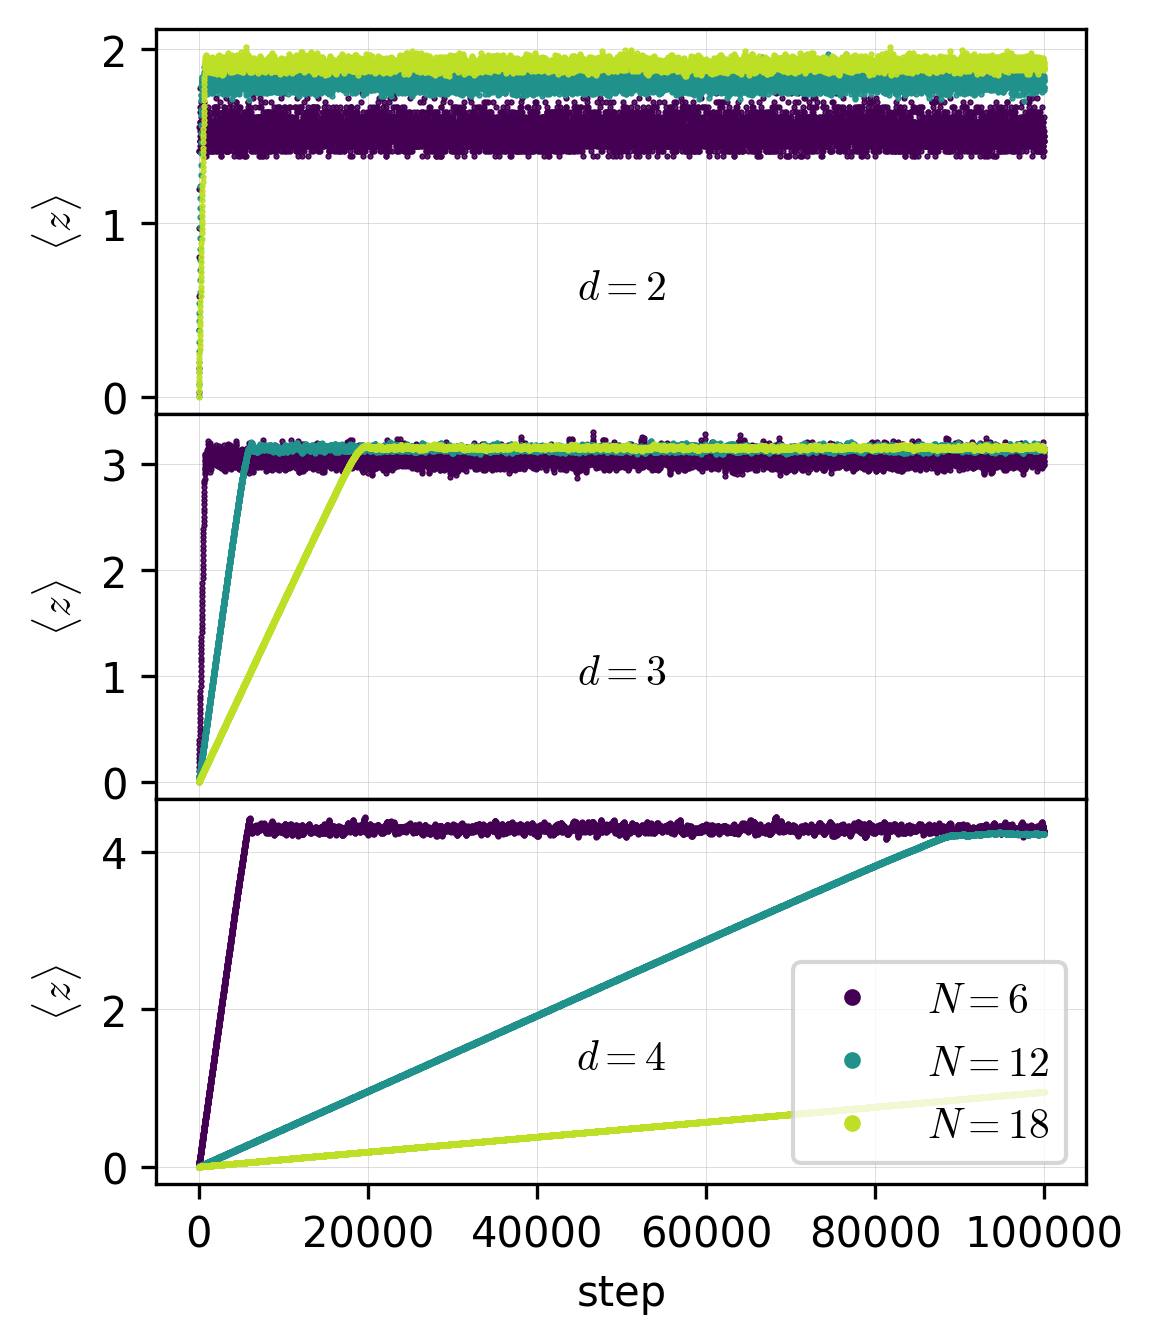

In [4]:
def plot_z_avg_examples():
    """Plots the z_avg evolution for a few d, N values."""

    N_vals = [6, 12, 18]
    d_vals = [2, 3, 4]

    fig, axs = plt.subplots(3, 1, figsize=(4, 5), sharex=True)

    for d, ax in zip(d_vals, axs):
        for N in N_vals:
            df = load_avalanches(d, N)

            if df is not None:
                df = df.iloc[:100000:10]
                ax.plot(df.index, df["z_avg"], '.', ms=1, label=f"$N = {N}$", color=N_colors[N])
        ax.set_ylabel(f"$\\langle z \\rangle$")
        ax.text(0.5, 0.33, f"$d = {d}$", transform=ax.transAxes, va="center", ha="center")

    axs[-1].legend(loc="lower right", markerscale=6)
    axs[-1].set_xlabel("step")

    plt.subplots_adjust(hspace=0)
    plt.savefig("Report/figs/z_avg_examples.png", bbox_inches="tight")
    plt.show()

plot_z_avg_examples()

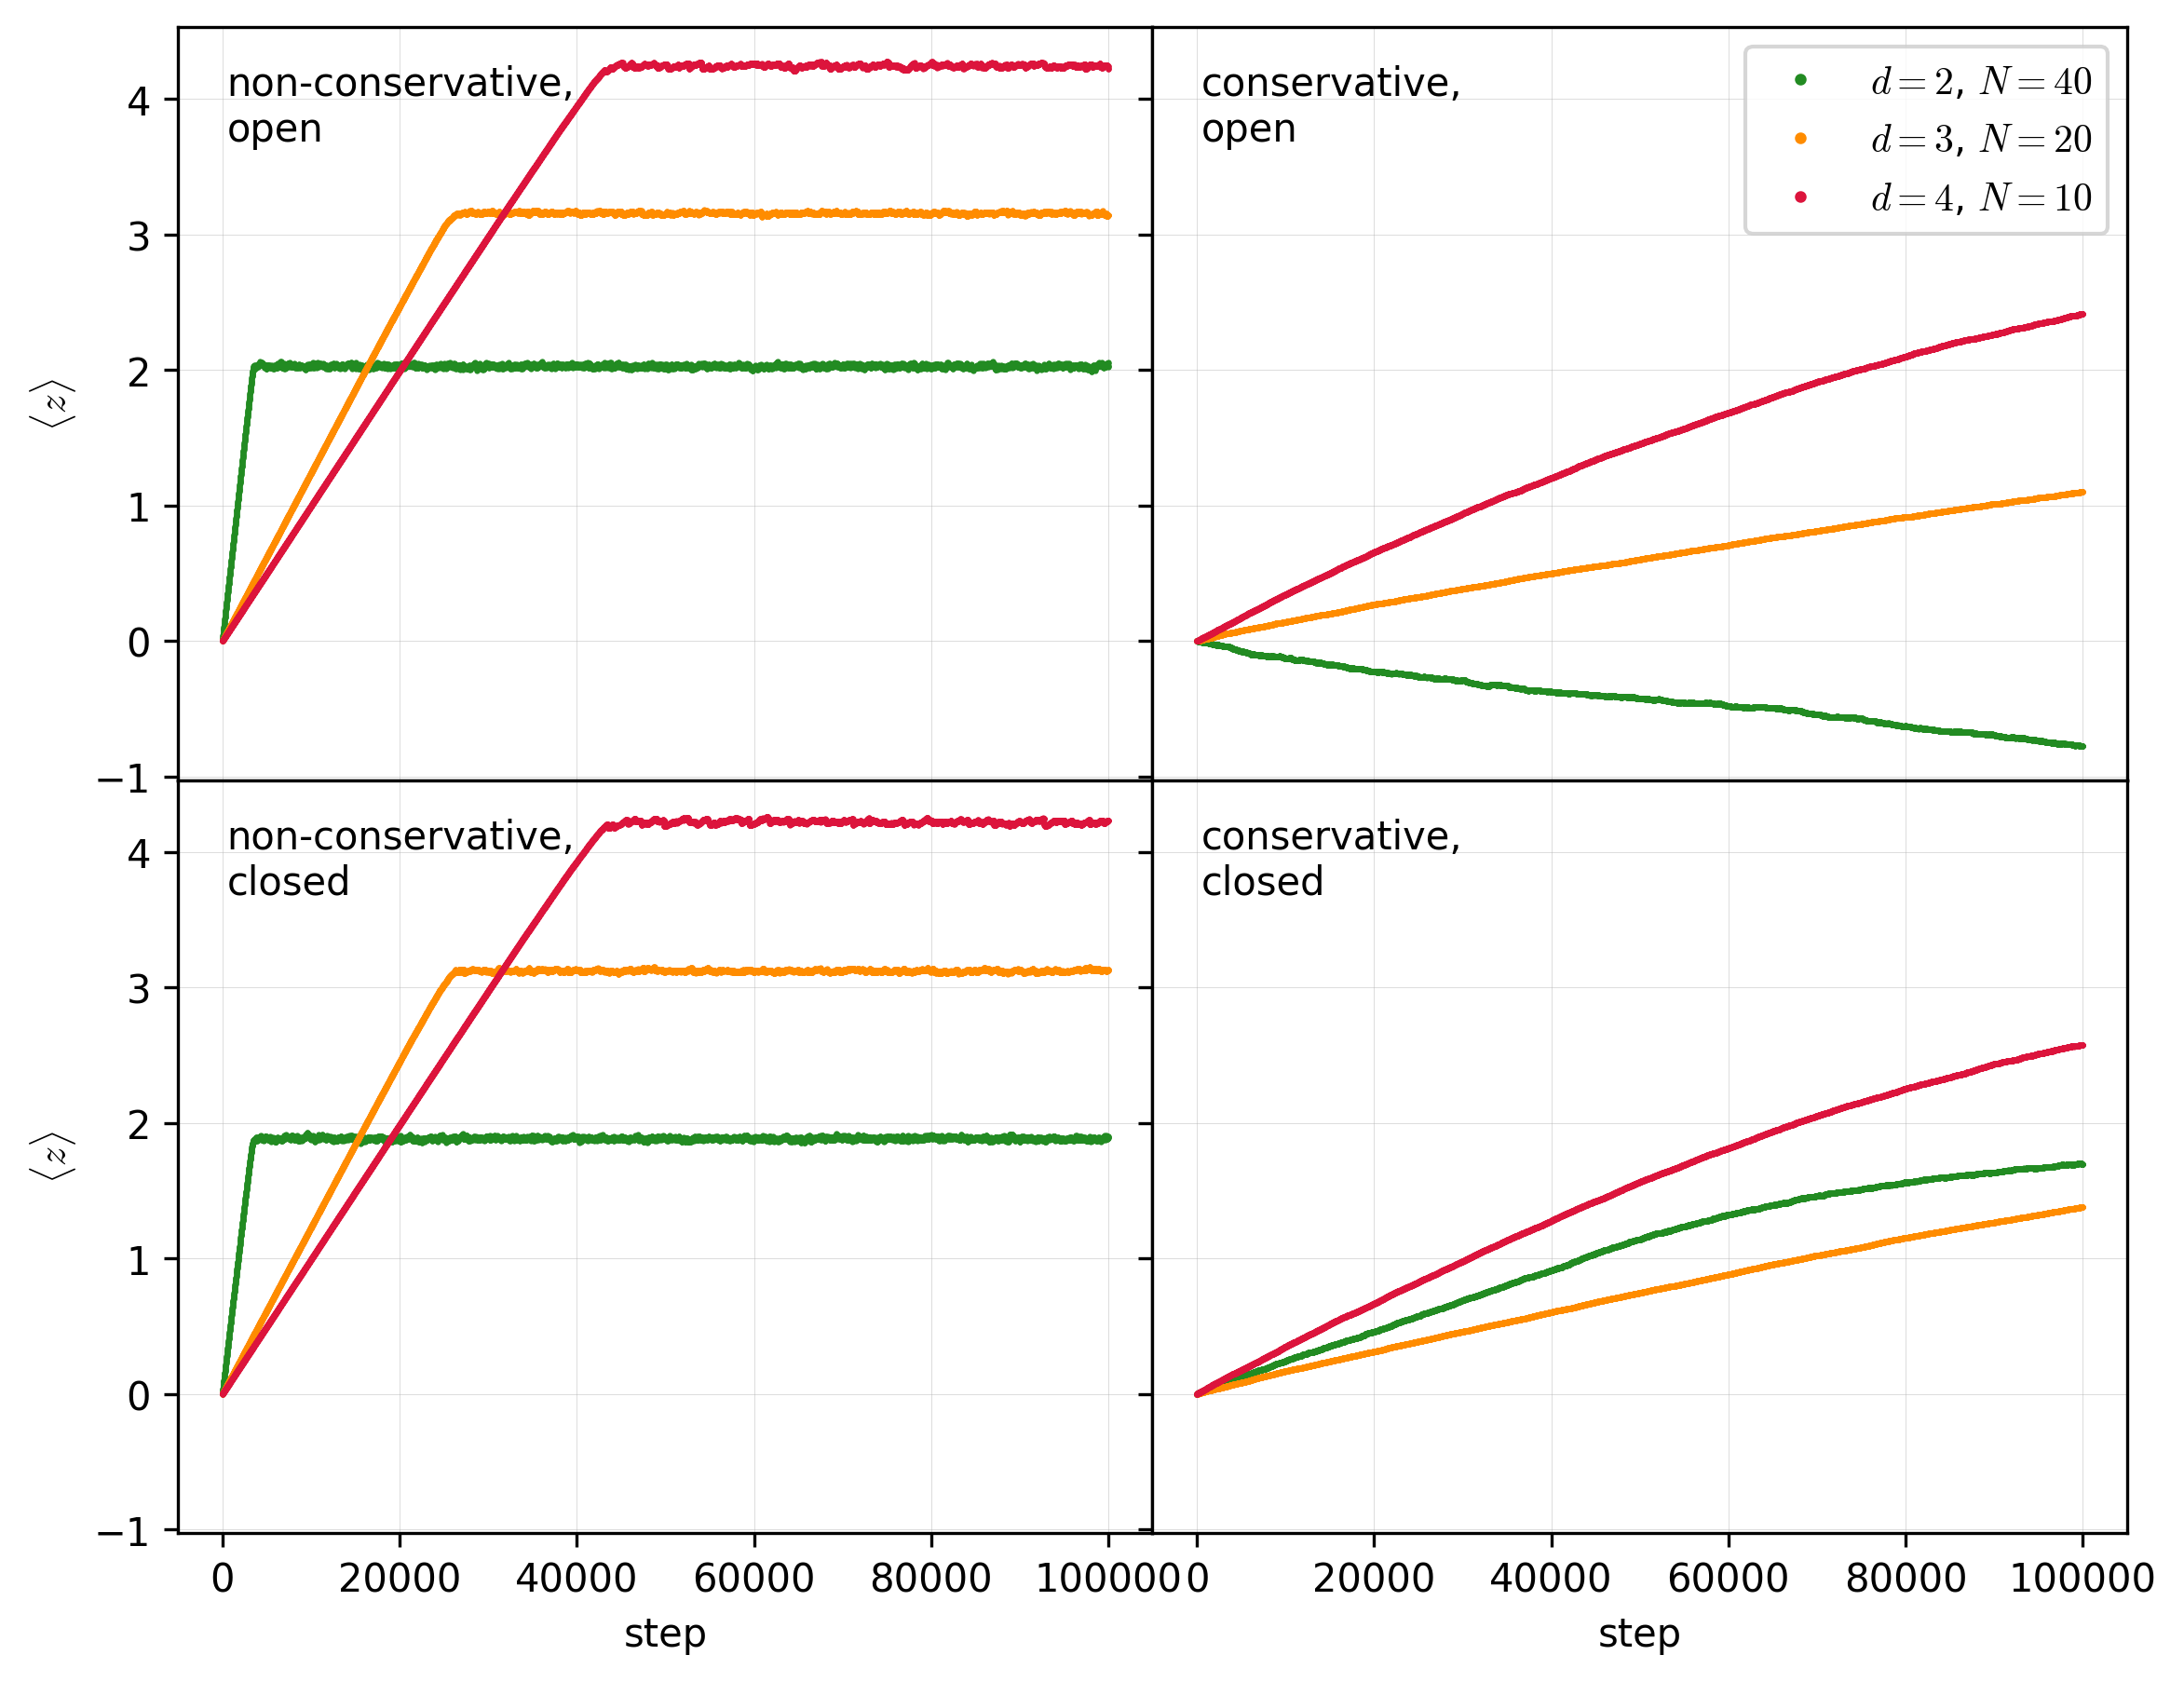

In [5]:
def plot_algorithm_comparisons():
    """Compare different boundary conditions and perturbation methods."""

    d_N_configs = [(2, 40), (3, 20), (4, 10)]

    fig, axs = plt.subplots(2, 2, figsize=(9, 7), sharex=True, sharey=True)

    for i, closed in enumerate([False, True]):
        for j, cons in enumerate([False, True]):
            ax = axs[i, j]

            for d, N in d_N_configs:
                df = load_avalanches(d, N, closed=closed, cons=cons)
                if df is None:
                    continue

                # select every 10th avalanche of the first 100000 to speed up plotting
                df = df.iloc[:100000:10]

                ax.plot(df.index, df["z_avg"], '.', ms=1, label=f"$d = {d}$, $N = {N}$", color=d_colors[d])

            text = (
                ("conservative" if cons else "non-conservative")
                + ",\n"
                + ("closed" if closed else "open")
            )

            ax.text(0.05, 0.95, text, transform=ax.transAxes, va="top", ha="left")

            if i == 1:
                ax.set_xlabel("step")
            if j == 0:
                ax.set_ylabel("$\\langle z \\rangle$")

    axs[0, 1].legend(loc="upper right", markerscale=4)

    plt.subplots_adjust(hspace=0, wspace=0)

    plt.savefig("Report/figs/alg_comparison.png", bbox_inches="tight")
    plt.show()

plot_algorithm_comparisons()

## Scaling exponents

In [6]:
# define variables which will be analyzed with corresponding symbols
vars = {"lifetime": "T", "size": "S", "linear_size": "L"}

# define scaling exponents for each variable
scaling_exponents = {"lifetime": "alpha", "size": "tau", "linear_size": "lambda"}

# define symbols for scaling exponents
scaling_exponent_symbols = {"alpha": "\\alpha", "tau": "\\tau", "lambda": "\\lambda"}

def get_significant_digits(x):
    return -int(np.floor(np.log10(np.abs(x))))

def format_err_val(val, err, digits=None):
    if digits is None:
        digits = get_significant_digits(err) + 1
    return f"{val:.{digits}f} \\pm {err:.{digits}f}"

def format_param_val(param, digits=None):
    return format_err_val(param.value, param.stderr, digits)

def get_thermalization_end(df, max_sigma=5):
    """
    Approximates the end of the thermalization phase by finding the first
    point where the z_avg value is more than max_sigma standard deviations
    away from the mean of the last 50000 points.
    """

    z_avg = df["z_avg"]
    n = len(z_avg)

    # Use last portion of data as thermalized reference
    end_size = 50000
    z_avg_end = z_avg[-end_size:]

    mean = z_avg_end.mean()
    std = z_avg_end.std()

    if std > .2:
        print(f"Warning: z_avg_end has high std = {std}")

    step = 1

    for therm_end in range(n - end_size, 1, -step):
        if abs(z_avg[therm_end] - mean) > max_sigma * std:
            return therm_end + 1
        
    return 0


def analyze_scaling_exponents(d, N, plot=True, save_as=None, closed=False):
    """
    Analyzes the scaling exponents of the avalanche for the given d, N by
    fitting the variables to a power law.
    """

    df = load_avalanches(d, N, closed=closed)

    results = {}

    therm_end = get_thermalization_end(df) + 100
    df = df.iloc[therm_end:]
    
    if plot:
        print(f"Removed thermalization until step {therm_end}. {len(df)} steps remaining.")
        plt.plot(df.index, df["z_avg"], '.k', ms=1)
        plt.xlabel("step")
        plt.ylabel("$\\langle z \\rangle$")
        plt.show()

        fig, axes = plt.subplots(1, len(vars), figsize=(8, 4), sharey=True)
    else:
        axes = [None] * len(vars)

    for ax, (var, var_symbol) in zip(axes, vars.items()):
        scaling_exp = scaling_exponents[var]
        scaling_exp_symbol = scaling_exponent_symbols[scaling_exp]
        x = df[var]
        x = x[x > 0]

        log_x = np.log(x)

        log_x_vals, log_x_counts = np.unique(log_x, return_counts=True)
        log_x_counts_err = np.sqrt(log_x_counts)
        
        p = log_x_counts / len(log_x)
        p_err = log_x_counts_err / len(log_x)

        log_x_vals = log_x_vals[p > 0]
        p_err = p_err[p > 0]
        p = p[p > 0]
        x_vals = np.exp(log_x_vals)

        log_p = np.log(p)
        log_p_err = p_err / p

        model = lmfit.Model(lambda x, e, c: (1 - e) * x + c)
        model.set_param_hint("e", value=0)
        model.set_param_hint("c", value=0)

        # impose linearity constraints
        if var == "lifetime":
            fit_region = (x_vals > 1) & (x_vals < N)
        elif var == "size":
            fit_region = (x_vals > 1) & (x_vals < 2 * N)
        elif var == "linear_size":
            fit_region = (x_vals < N / 3)
        else:
            fit_region = np.ones_like(x_vals, dtype=np.bool_)

        if np.sum(fit_region) < 3:
            result = None
        else:
            result = model.fit(log_p[fit_region], x=log_x_vals[fit_region], weights=1 / log_p_err[fit_region])

        results[var] = result

        if plot:
            # Data
            ax.errorbar(log_x_vals, log_p, yerr=log_p_err, fmt='.', c="#aaa", ms=0, capsize=2, label="errors")
            ax.plot(log_x_vals, log_p, ".k", zorder=10, ms=4, label="data")

            # Fit
            if result:
                ax.plot(result.userkws["x"], result.best_fit, "-r", label="fit", zorder=100)

                ax.set_xlabel(f"$\\log {var_symbol.lower()}$")
                ax.text(.93, 1,
                    (
                        f"${scaling_exp_symbol} = {format_param_val(result.params['e'], 3)}$\n"
                        f"$c_{var_symbol} = {format_param_val(result.params['c'], 3)}$\n"
                        f"$\\chi^2_\\mathrm{{red}} = {result.redchi:.3f}$"
                    ),
                    transform=ax.transAxes, va="top", ha="right",
                    linespacing=1.8,
                    bbox=dict(facecolor="w", linewidth=.7, pad=5)
                )

            min_i = np.argmin(log_p)
            ax.set_ylim((log_p[min_i] - log_p_err[min_i]) * 1.03, None)

    if plot:
        axes[0].set_ylabel(f"$\\log P$")
        axes[0].legend(loc="lower left")

        plt.subplots_adjust(wspace=0)

        if save_as:
            plt.savefig(f"Report/figs/{save_as}", bbox_inches="tight")
        plt.show()

    return results

# d = 2

Removed thermalization until step 293. 100007 steps remaining.


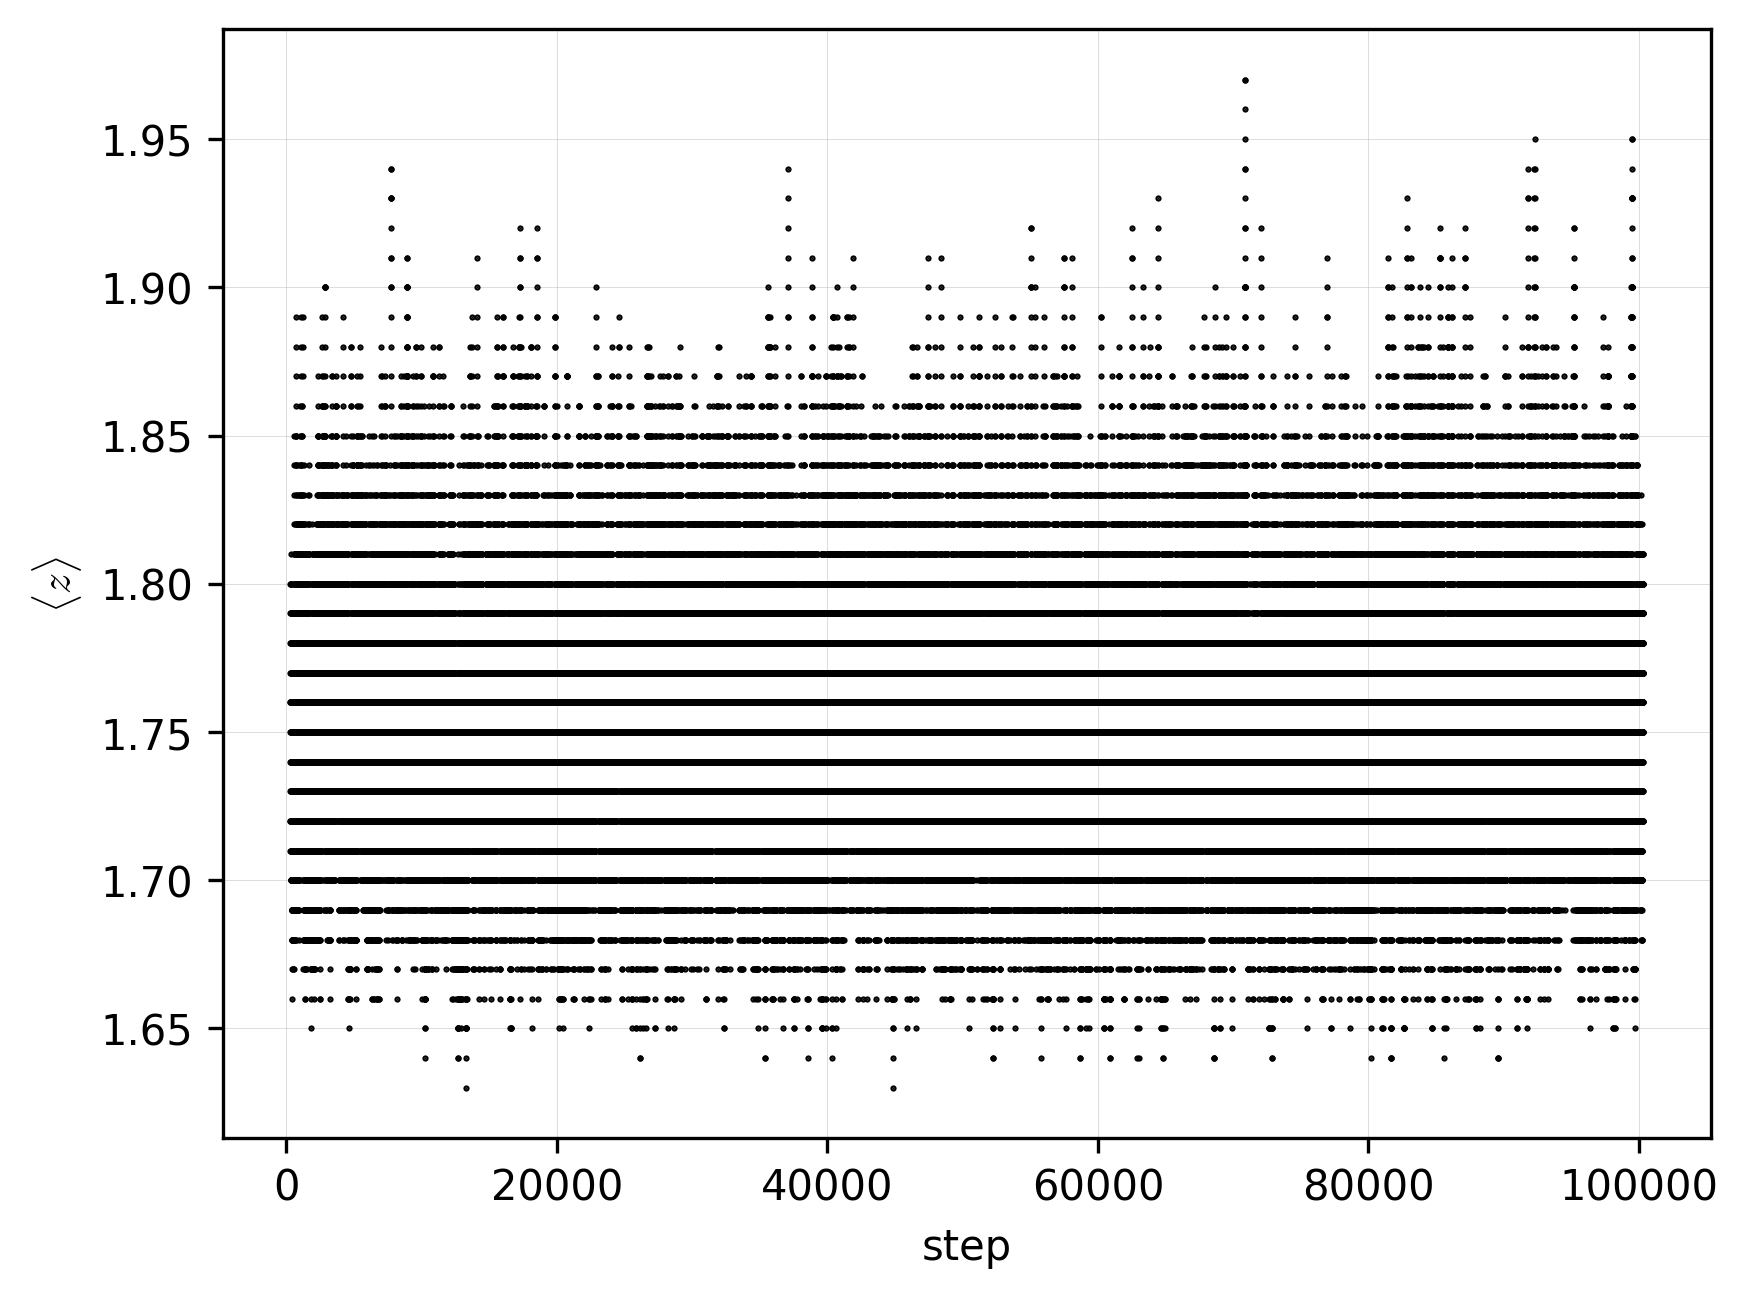

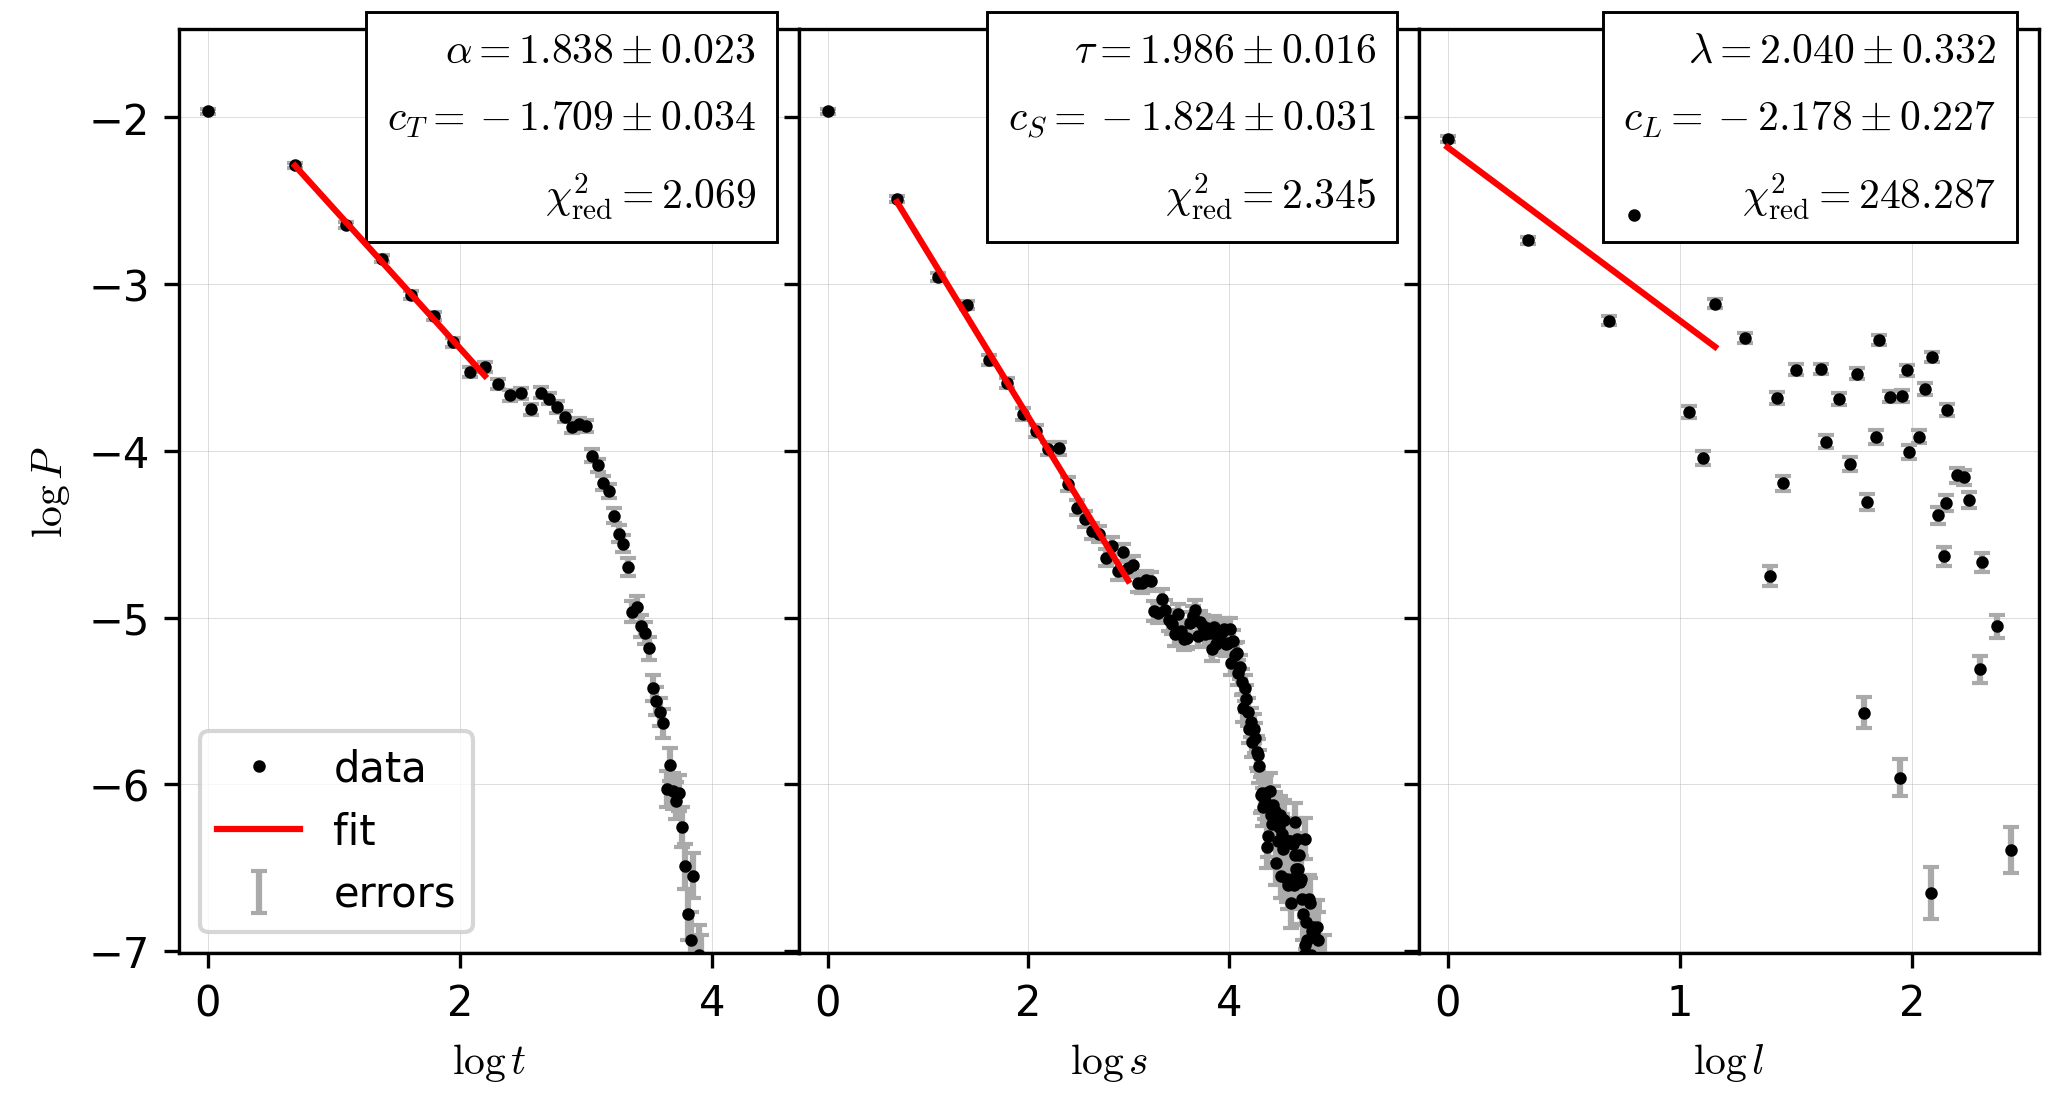

In [7]:
analyze_scaling_exponents(d=2, N=10);

Removed thermalization until step 3496. 101304 steps remaining.


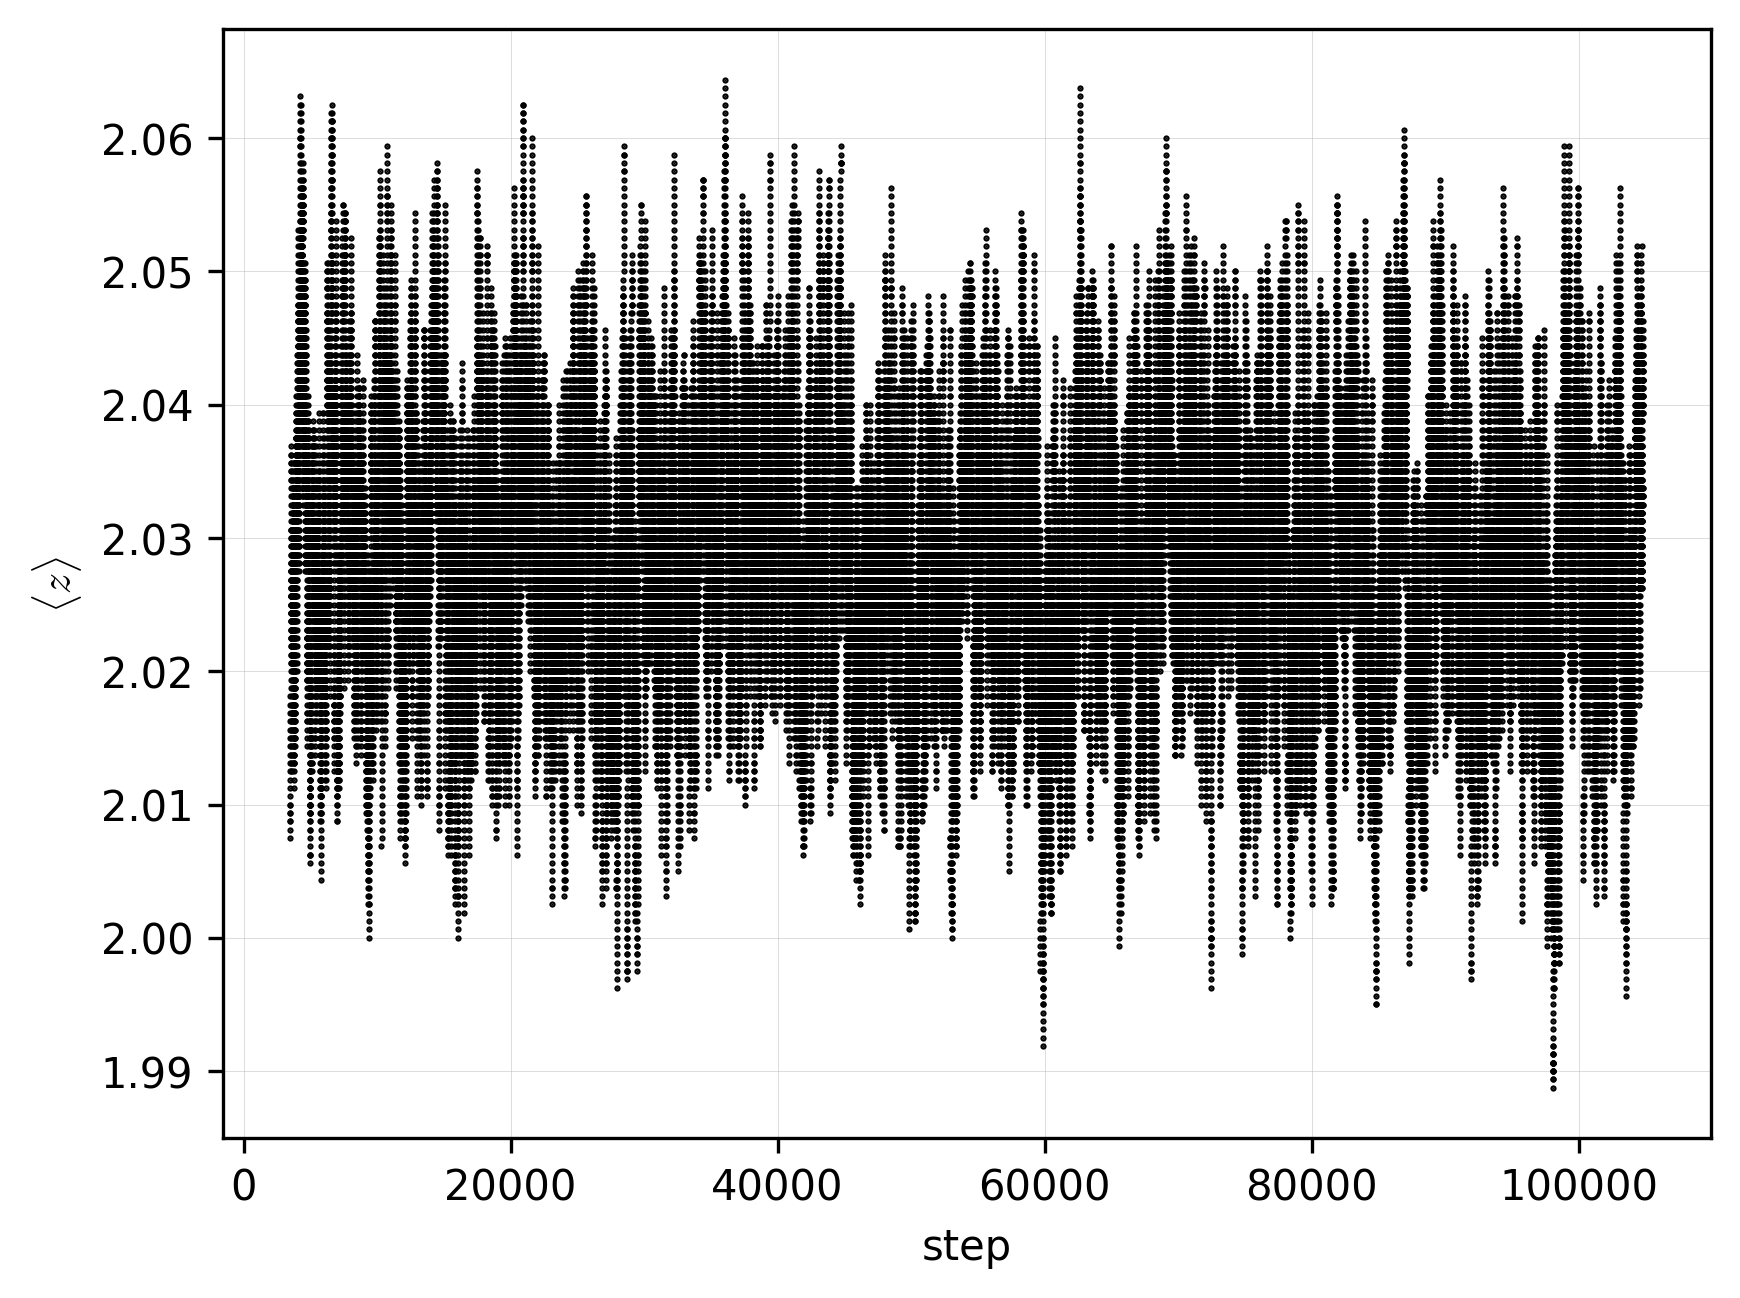

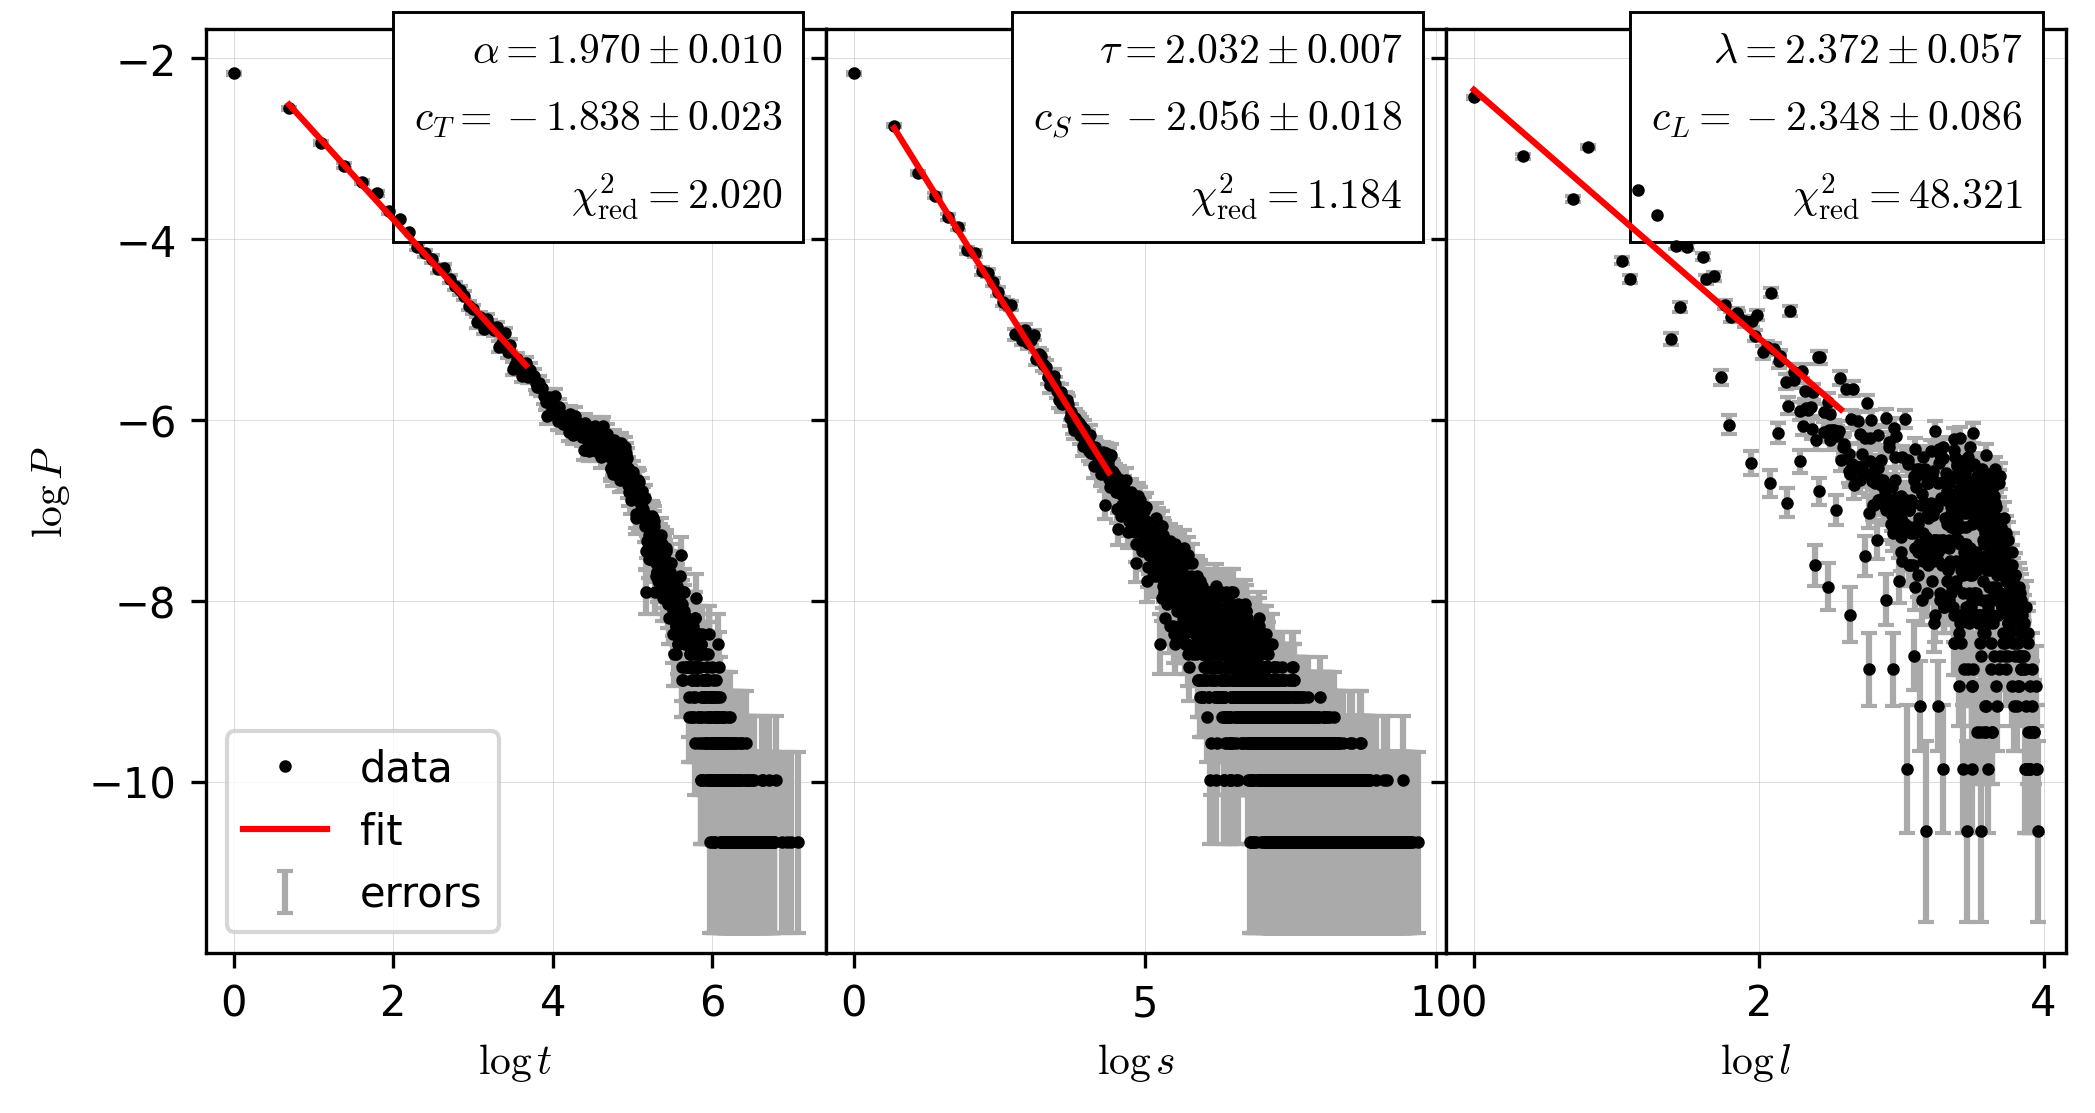

In [8]:
analyze_scaling_exponents(d=2, N=40, save_as="result_scaling_exp_fit.png");

# d = 3

Removed thermalization until step 86861. 148139 steps remaining.


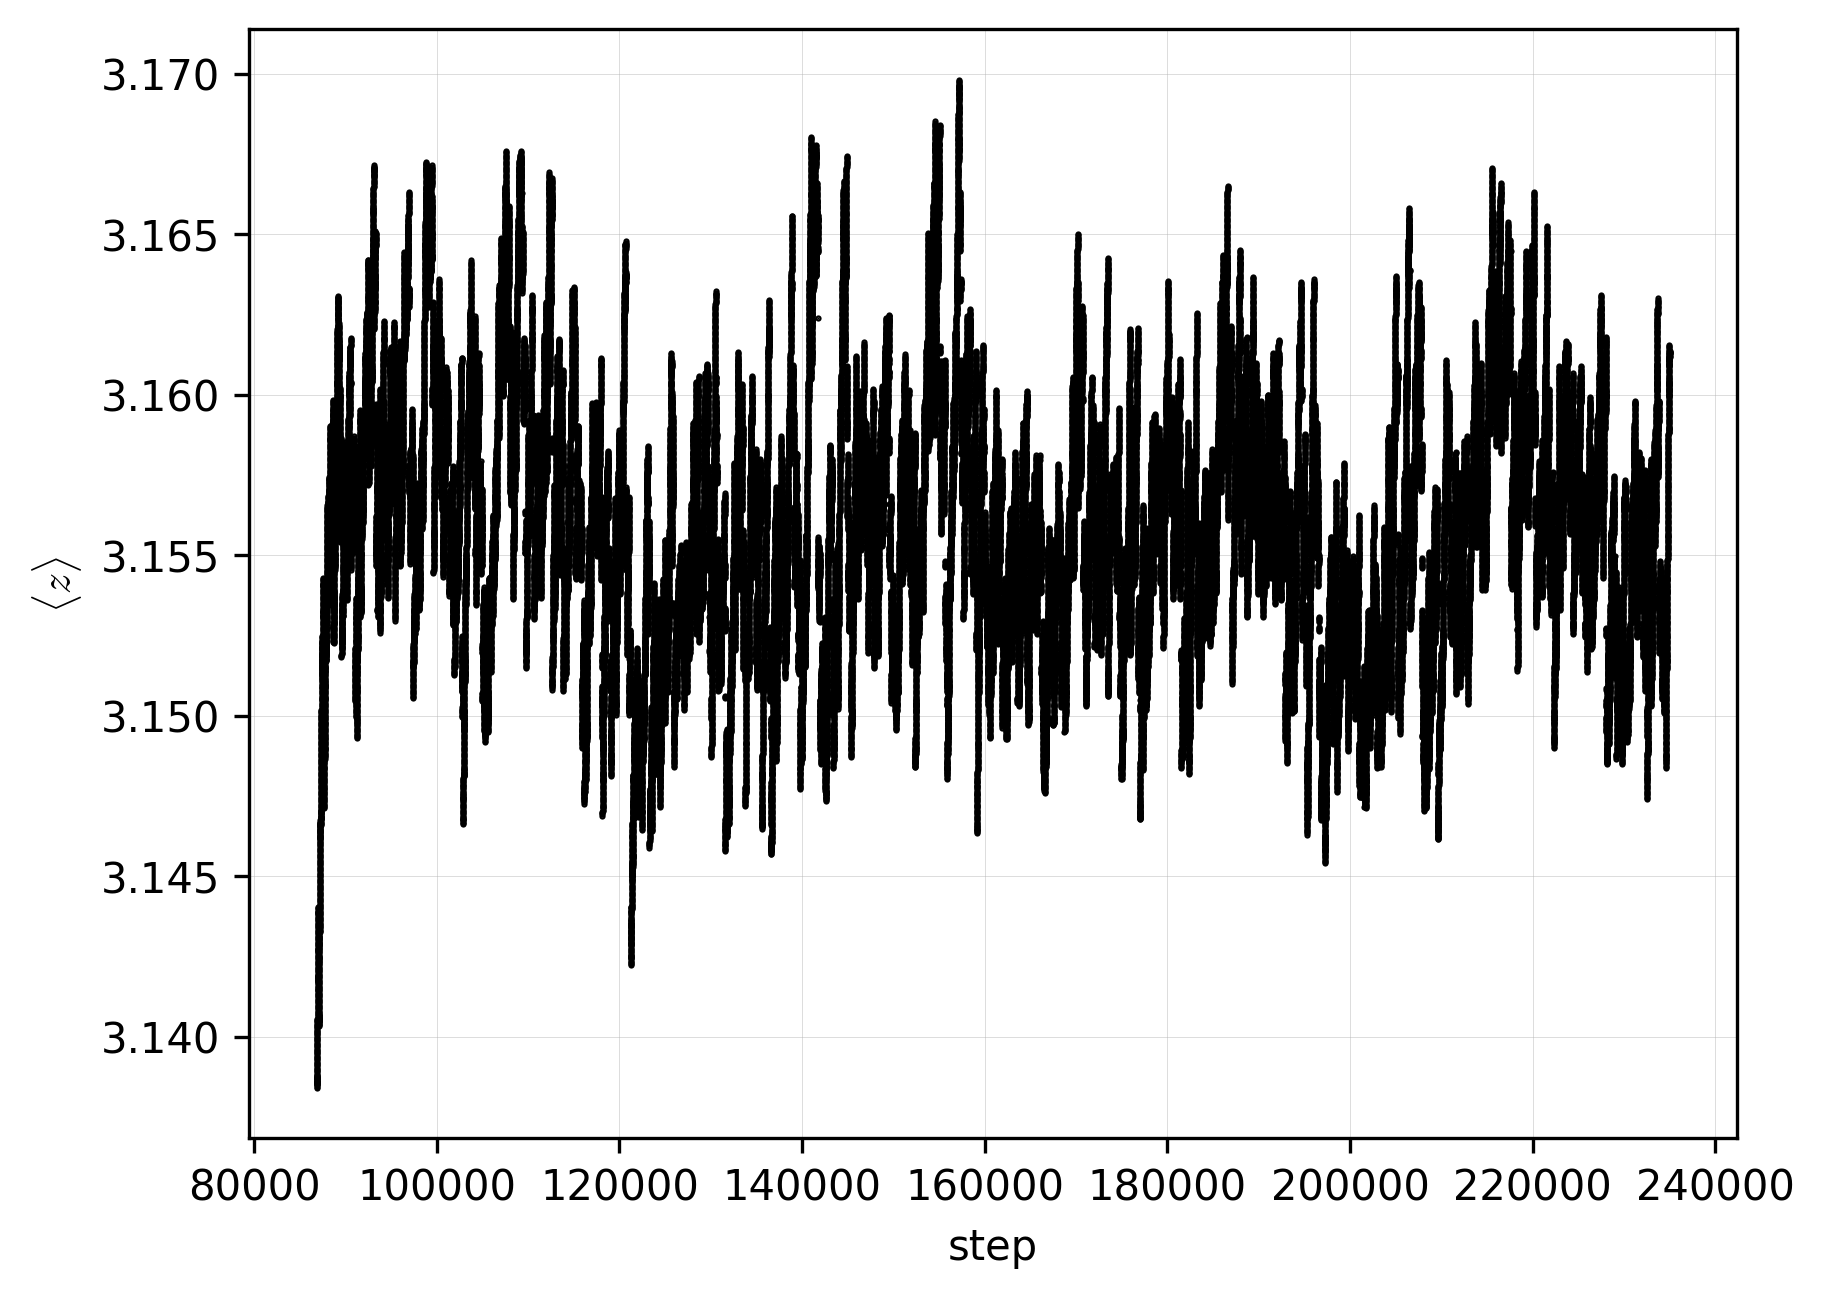

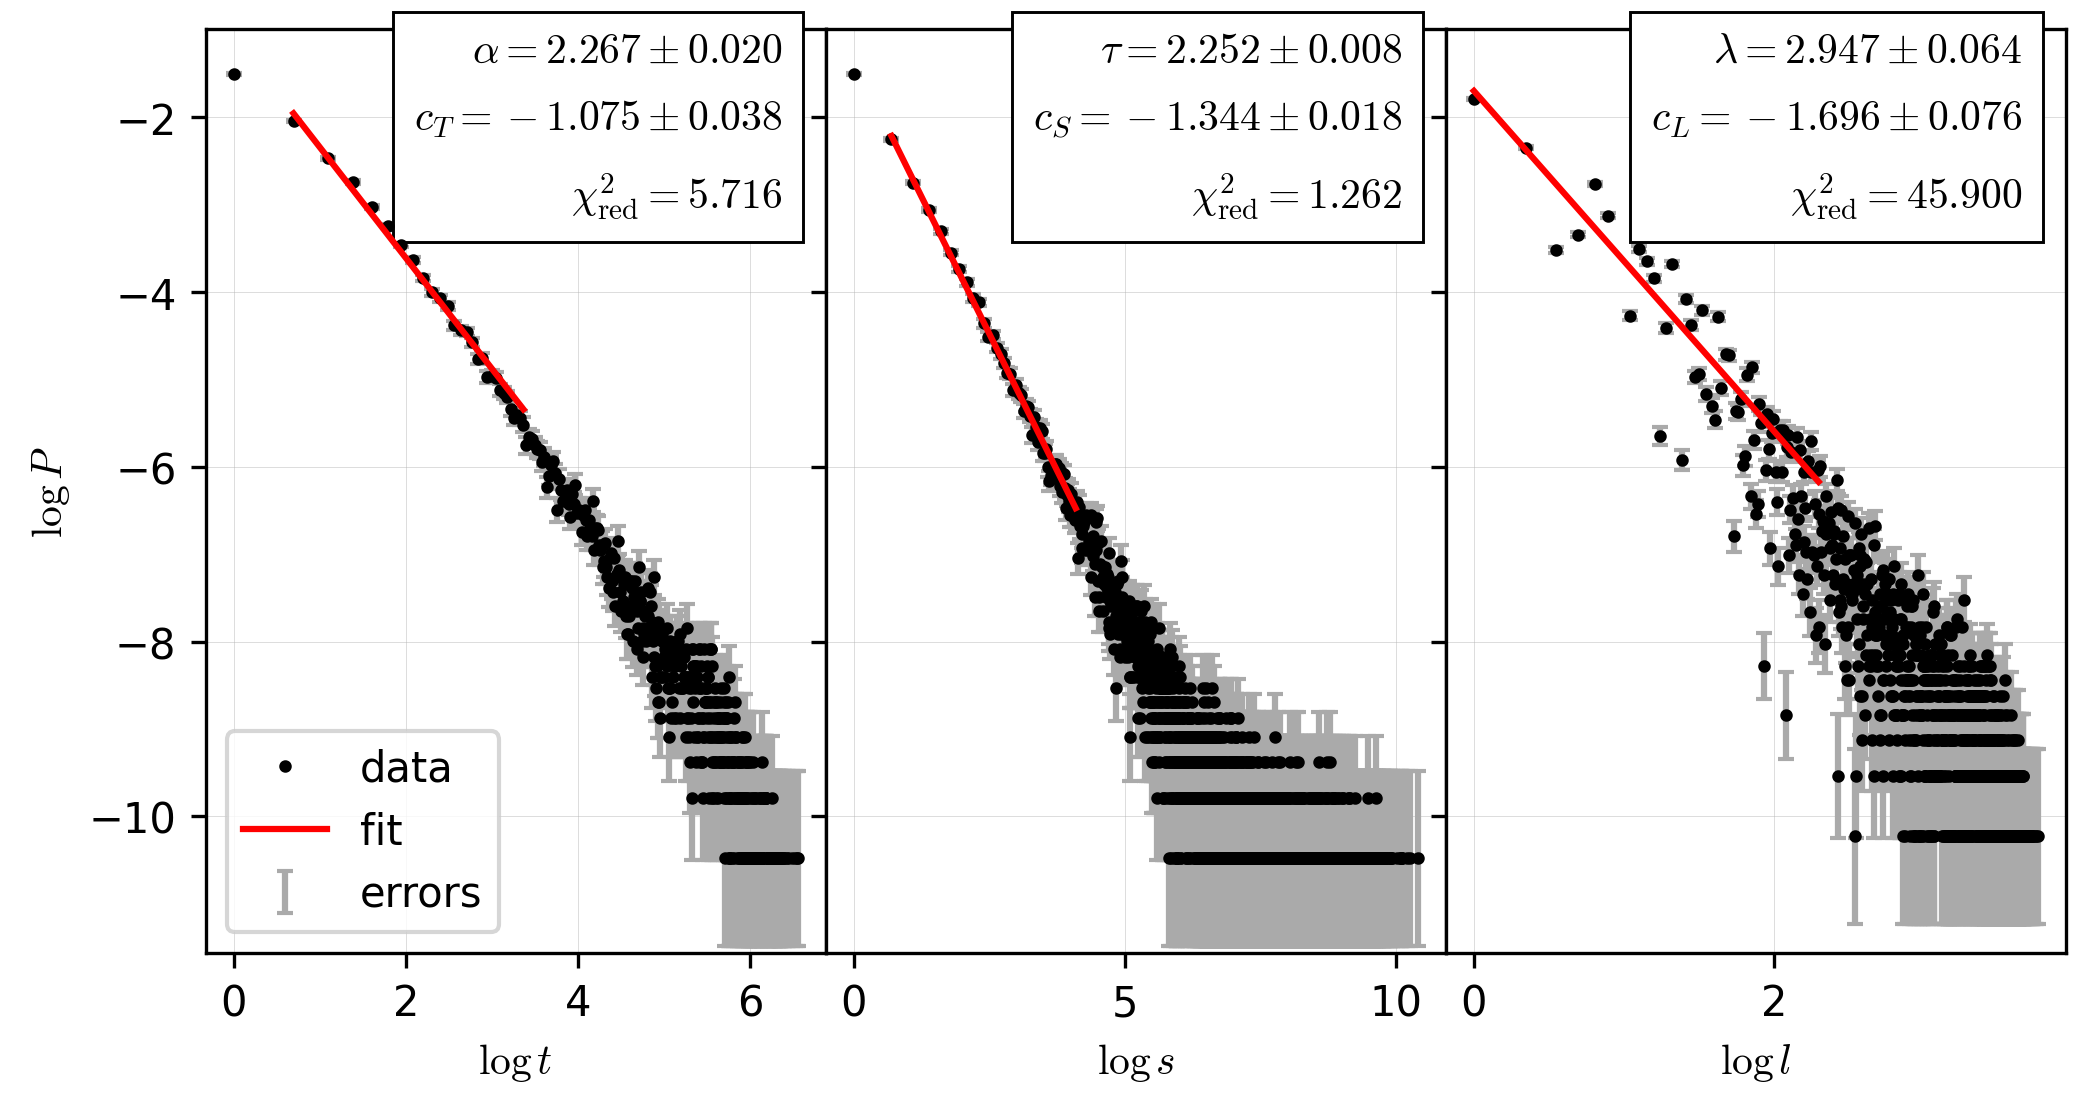

In [9]:
analyze_scaling_exponents(d=3, N=30);

# d = 4

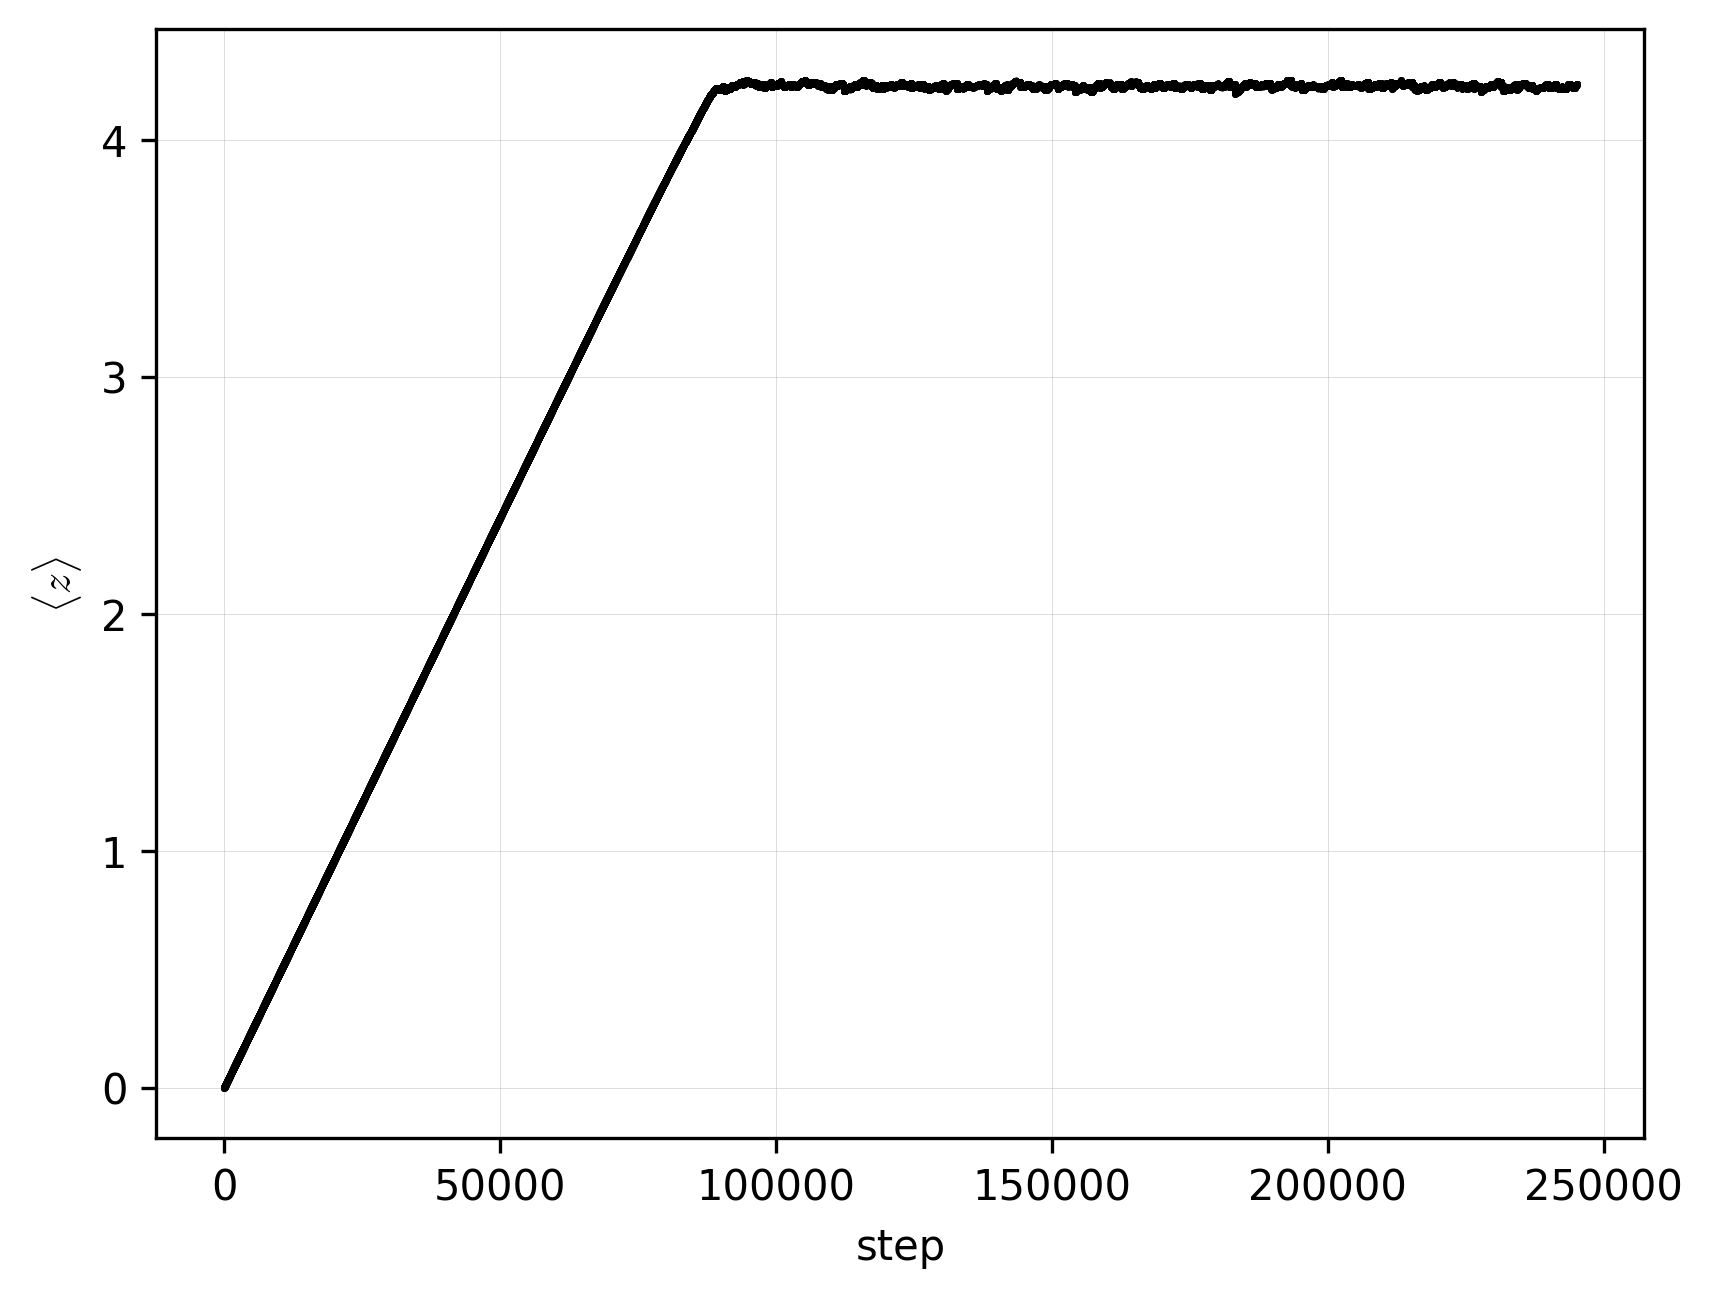

Removed thermalization until step 88175. 156977 steps remaining.


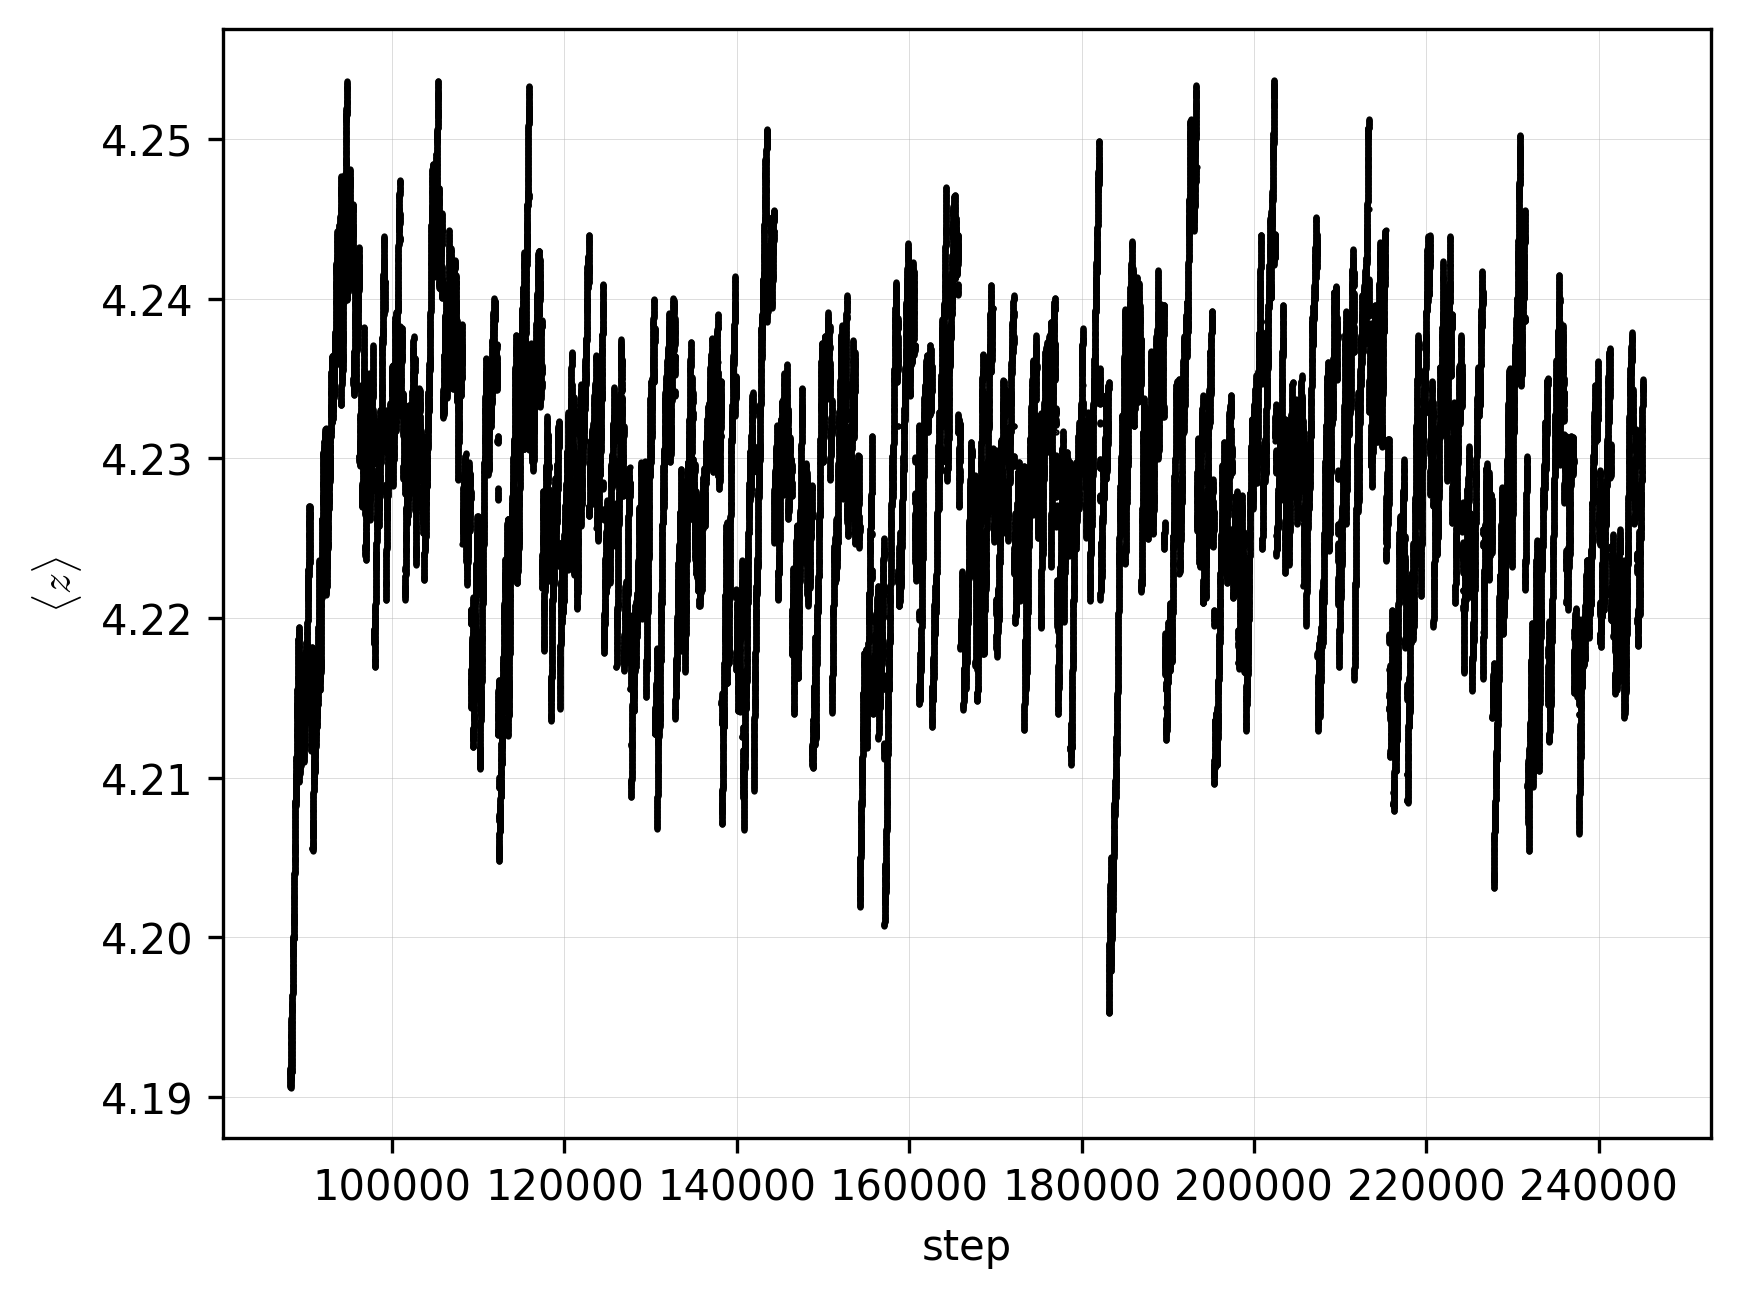

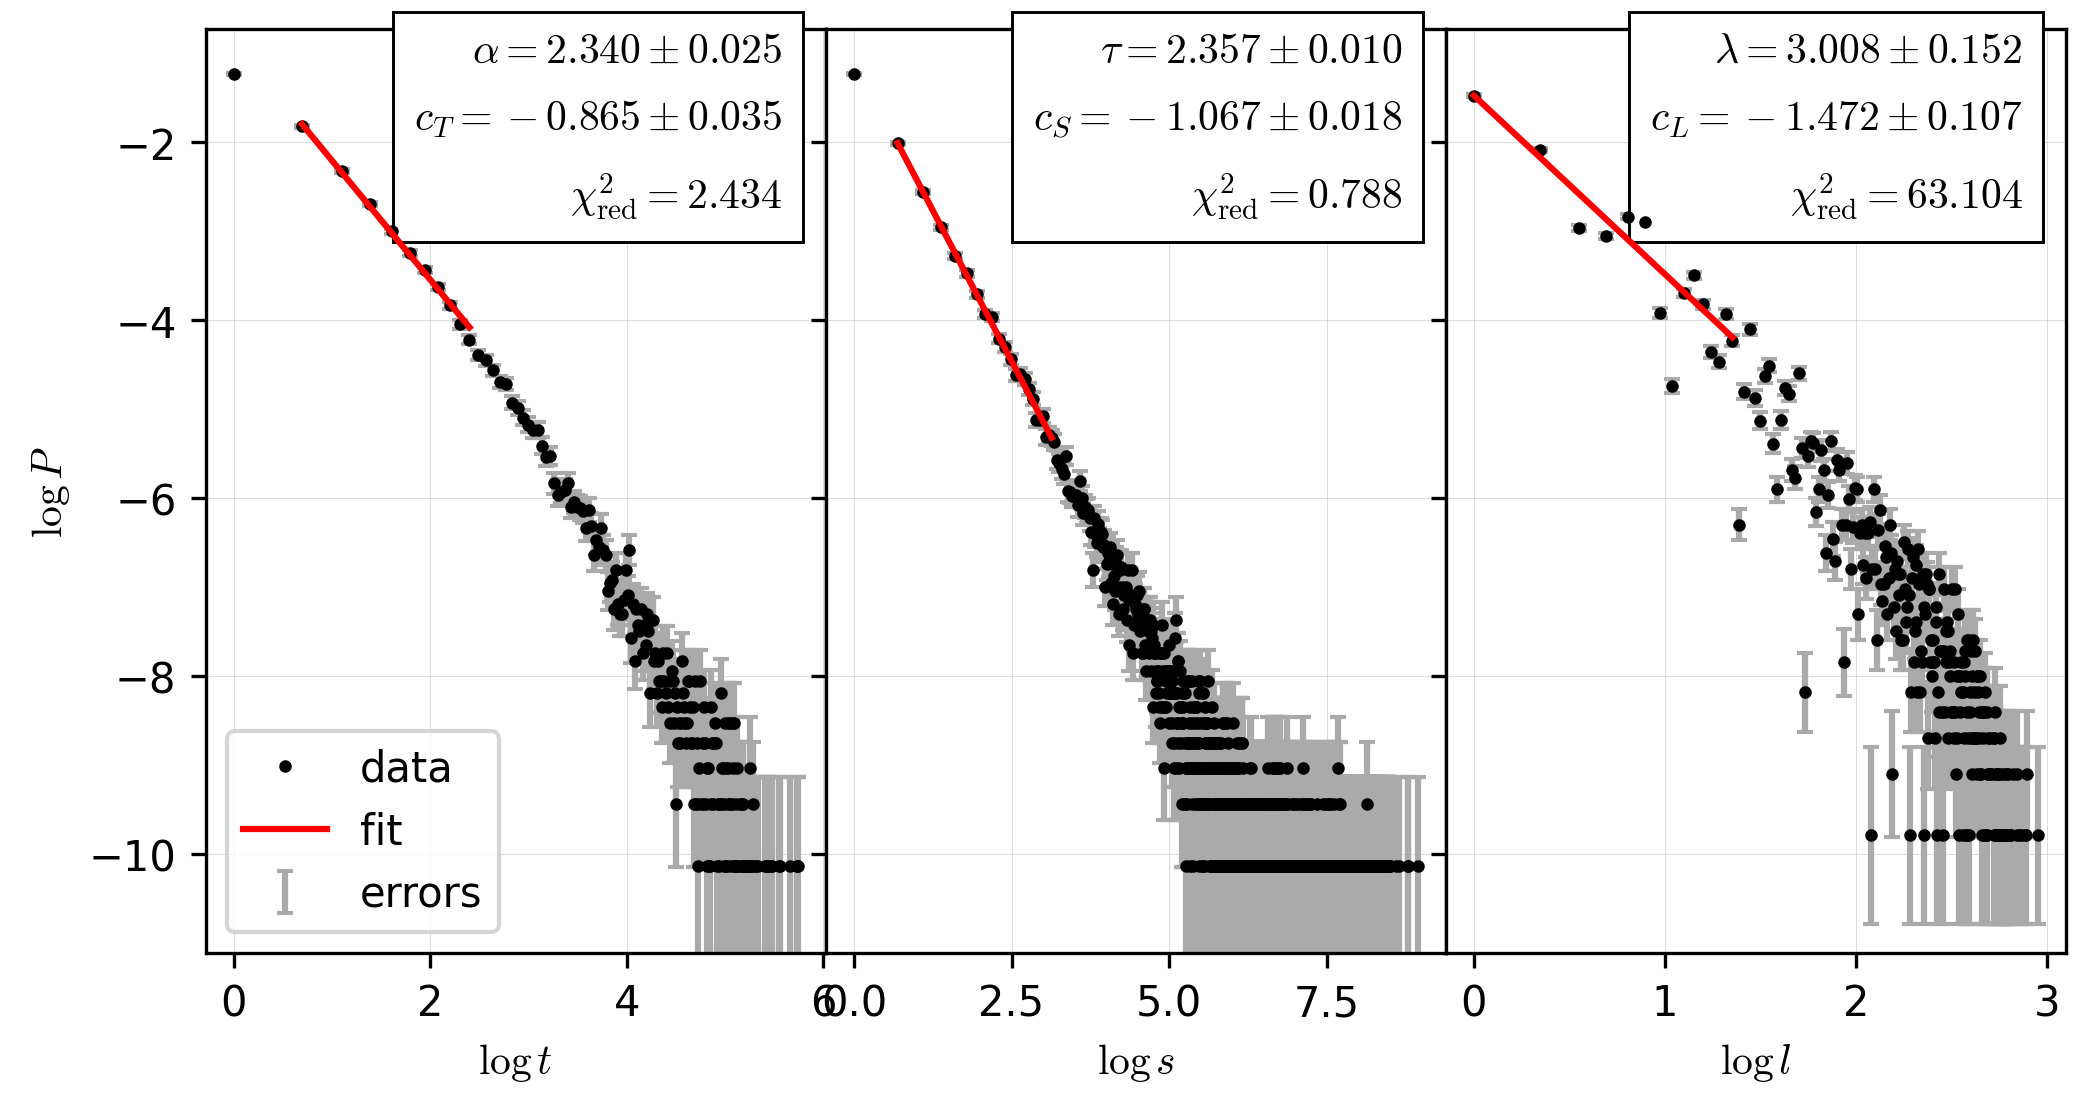

In [10]:
plot_z_avg(d=4, N=12)
analyze_scaling_exponents(d=4, N=12);

In [11]:
def analyze_scaling_exponents_for_all_N(d):
    data = []

    N_vals = get_avalanche_N_vals(d)

    for N in N_vals:
        results = analyze_scaling_exponents(d, N, plot=False)

        row = {"N": N}

        for var, scaling_exp in scaling_exponents.items():
            result = results[var]
            if result is not None:
                row[scaling_exp] = result.params["e"].value
                row[scaling_exp + "_err"] = result.params["e"].stderr
        
        data.append(row)

    return pd.DataFrame(data).sort_values("N")

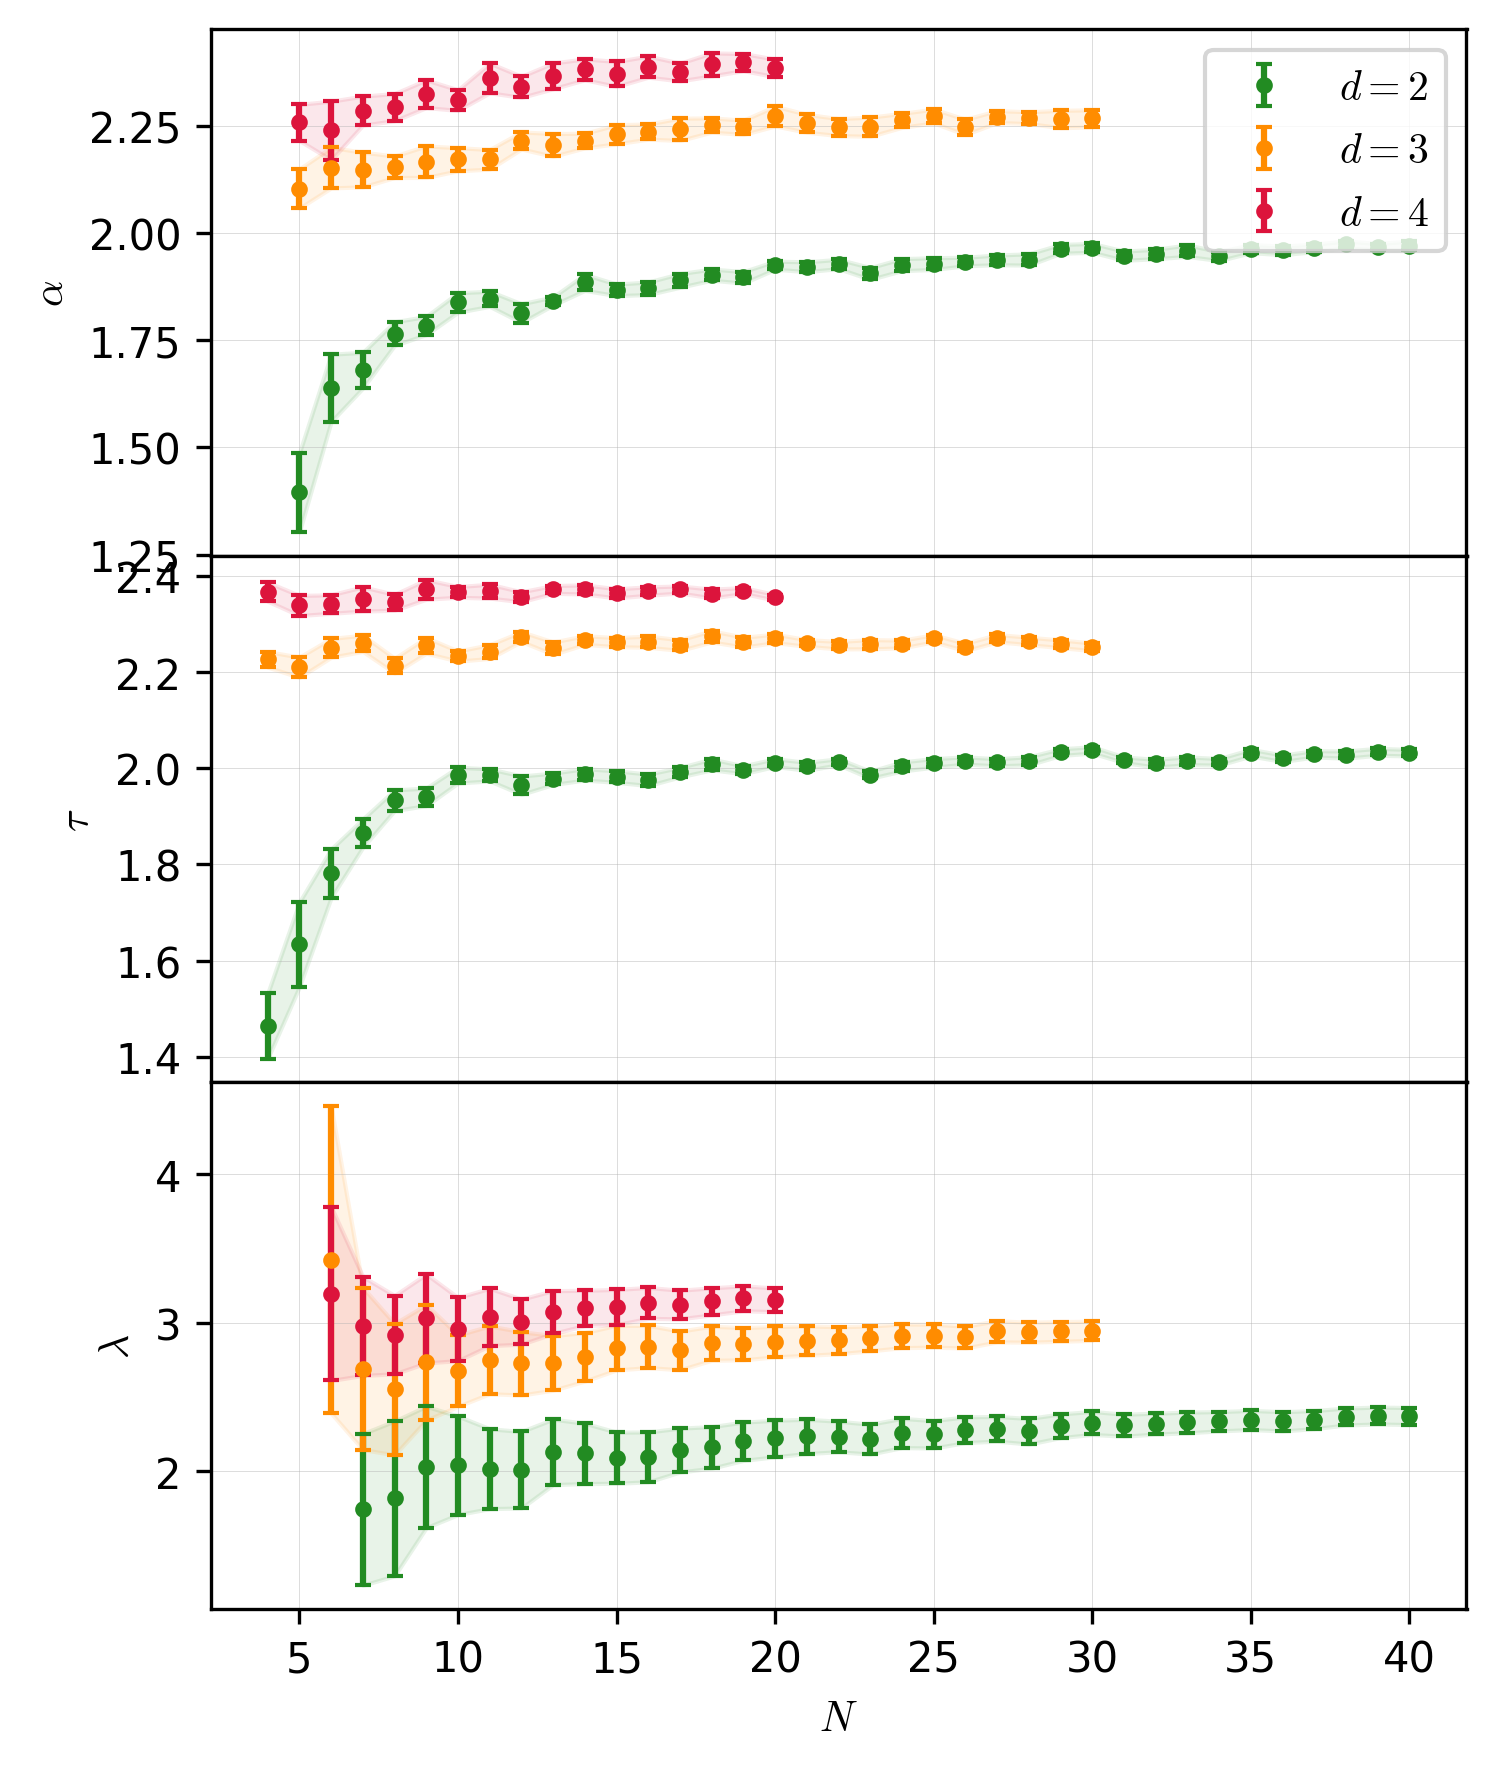

In [12]:
# This plots each exponent in a seperate plot
def compare_grid_sizes():
    fig, axs = plt.subplots(3, 1, figsize=(5, 6), sharex=True)


    d_vals = [2, 3, 4]
    scaling_exp_dfs = [analyze_scaling_exponents_for_all_N(d) for d in d_vals] 

    for (scaling_exp, scaling_exp_symbol), ax in zip(scaling_exponent_symbols.items(), axs):
        for d, scaling_exp_df in zip(d_vals, scaling_exp_dfs):
            N_vals = scaling_exp_df["N"]
            e_vals = scaling_exp_df[scaling_exp]
            e_errs = scaling_exp_df[scaling_exp + "_err"]

            color = d_colors[d]
            ax.errorbar(N_vals, e_vals, yerr=e_errs, fmt=".", c=color, capsize=2, label=f"$d = {d}$")
            ax.fill_between(N_vals, e_vals - e_errs, e_vals + e_errs, color=color, alpha=.1)

        ax.set_ylabel(f"${scaling_exp_symbol}$")

    axs[-1].set_xlabel("$N$")

    axs[0].legend(loc="upper right")

    plt.tight_layout()
    plt.subplots_adjust(hspace=0)
    plt.savefig("Report/figs/scaling_exp_compare_grid_sizes.png", bbox_inches="tight")

compare_grid_sizes()

## Scaling exponents $\gamma_i$ ("conditional exponents")

In [15]:
# define the scaling exponents for conditional expectation values
cond_exponents = {
    ("lifetime", "size"): "gamma_1",
    ("size", "lifetime"): "gamma_1_inv",
    ("linear_size", "size"): "gamma_2",
    ("size", "linear_size"): "gamma_2_inv",
    ("linear_size", "lifetime"): "gamma_3",
    ("lifetime", "linear_size"): "gamma_3_inv",
}

cond_exponent_symbols = {
    "gamma_1": "\\gamma_1",
    "gamma_1_inv": "\\overline{\\gamma}_1",
    "gamma_2": "\\gamma_2",
    "gamma_2_inv": "\\overline{\\gamma}_2",
    "gamma_3": "\\gamma_3",
    "gamma_3_inv": "\\overline{\\gamma}_3",
}

def fit_exp_val(df, x, y, d, N):
    df = df.query(f"{x} > 0 and {y} > 0") # Remove non-positive values for log

    x_groups = df.groupby(x)
    exp_val_df = x_groups.mean()
    exp_val_err_df = x_groups.std()

    x_vals = exp_val_df.index
    E_vals = exp_val_df[y]
    # err is at least 1, since we work with integers
    E_errs = np.maximum(1, exp_val_err_df[y])

    nonzero = (x_vals > 0) & (E_vals > 0) & (E_errs > 0)

    x_vals, E_vals, E_errs = x_vals[nonzero], E_vals[nonzero], E_errs[nonzero]

    log_x = np.log(x_vals)
    log_E = np.log(E_vals)
    log_E_err = E_errs / E_vals

    assert np.all(log_E_err > 0), "Error in log(E) must be positive"

    model = lmfit.Model(lambda x, e, c: e * x + c)
    model.set_param_hint("e", value=1)
    model.set_param_hint("c", value=0)


    if x == "lifetime":
        # Why is that?
        fit_region = (x_vals > 1) & (x_vals < N)
    elif x == "size":
        fit_region = (x_vals > 1) & (x_vals < 2 * N)
    elif x == "linear_size":
        fit_region = (x_vals < N / 3)
    else:
        fit_region = np.ones_like(x_vals, dtype=np.bool_)        

    if y == "lifetime":
        # Why is that?
        fit_region &= (E_vals > 1) & (E_vals < N)
    elif y == "size":
        fit_region &= (E_vals > 1) & (x_vals < 2 * N)
    elif y == "linear_size":
        fit_region &= (E_vals < N / 3)
    else:
        fit_region &= np.ones_like(E_vals, dtype=np.bool_)

    if np.sum(fit_region) < 3:
        result = None
    else:
        result = model.fit(log_E[fit_region], x=log_x[fit_region], weights=1 / log_E_err[fit_region])

    return log_x, log_E, log_E_err, result


def analyze_cond_exponents(d, N, plot=True, save_as=None):
    df = load_avalanches(d, N)
    therm_end = get_thermalization_end(df) + 100
    df = df.iloc[therm_end:]

    if plot:
        fig, axs = plt.subplots(len(vars), len(vars) - 1, dpi=200, figsize=(8, 7), constrained_layout=True)
        axs = axs.flatten()

    cond_exp_vals = []
    cond_exp_errs = []

    for i, ((x, y), cond_exp) in enumerate(cond_exponents.items()):
        cond_exp_symbol = cond_exponent_symbols[cond_exp]

        log_x, log_E, log_E_err, result = fit_exp_val(df, x, y, d, N)
        if result:
            e = result.params["e"].value
            e_err = result.params["e"].stderr
        else:
            e = e_err = np.nan

        if plot:
            ax = axs[i]
            ax.set_xlabel(f"$\\log {vars[x].lower()}$")
            ax.set_ylabel(f"$\\log E({vars[y]} \\:|\\: {vars[x]} = {vars[x].lower()})$")

            # Data
            ax.errorbar(log_x, log_E, yerr=log_E_err, fmt='.', c="#aaa", ms=0, capsize=2, label="errors")
            ax.plot(log_x, log_E, ".k", zorder=10, ms=4, label="data")

            # Fit
            if result:
                ax.plot(result.userkws["x"], result.best_fit, "-r", label="fit", zorder=100)
                
                ax.text(.96, .06,
                    (
                        f"${cond_exp_symbol} = {format_param_val(result.params['e'], 3)}$\n"
                        f"$c = {format_param_val(result.params['c'], 3)}$\n"
                        f"$\\chi^2_\\mathrm{{red}} = {result.redchi:.3f}$"
                    ),
                    transform=ax.transAxes, va="bottom", ha="right",
                    linespacing=1.8,
                    bbox=dict(facecolor="w", linewidth=.7, pad=5)
                )

        cond_exp_vals.append(e)
        cond_exp_errs.append(e_err)


    if plot:
        axs[0].legend(loc="upper left")
        if save_as:
            plt.savefig(f"Report/figs/{save_as}", bbox_inches="tight")
        plt.show()
        
    return np.array(cond_exp_vals), np.array(cond_exp_errs)

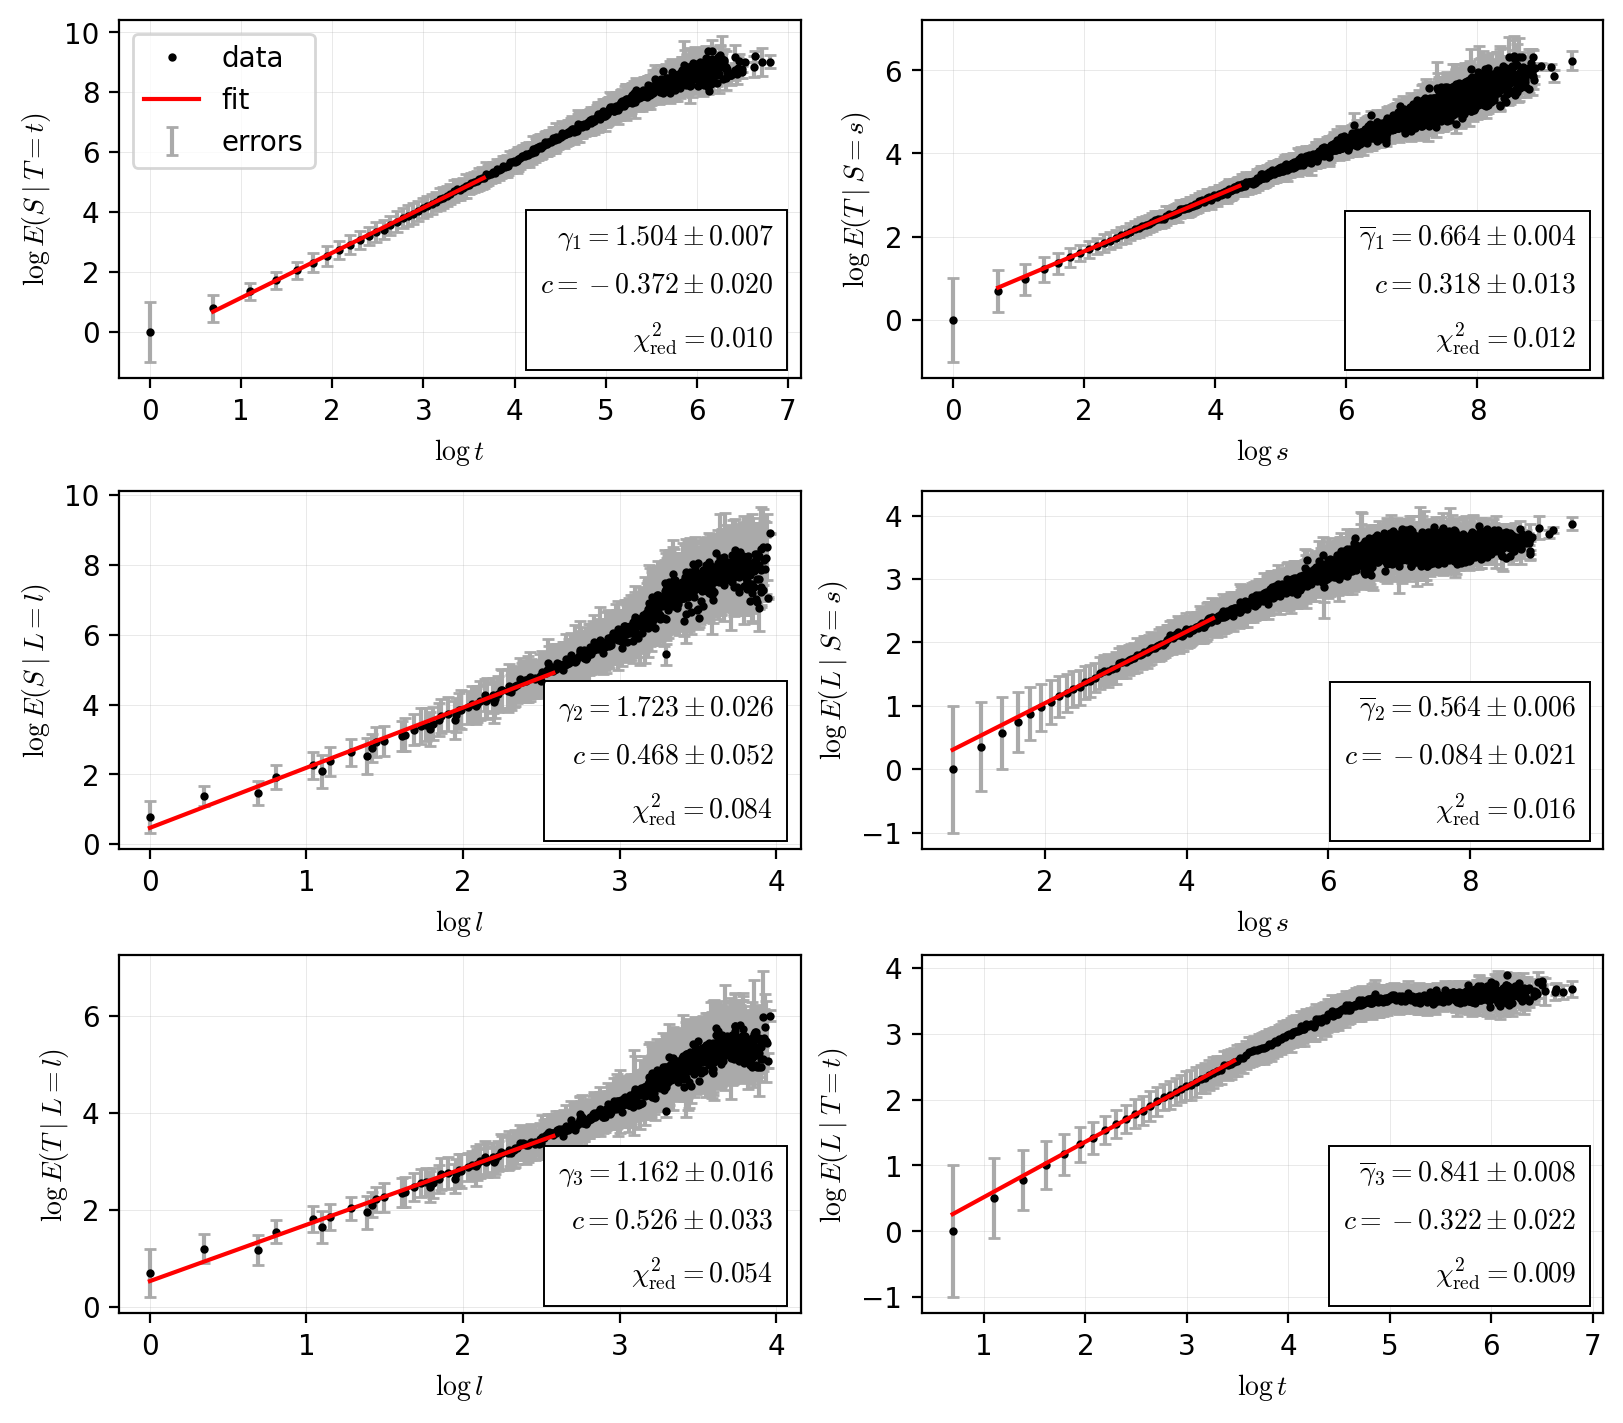

(array([1.50391293, 0.6644258 , 1.72263504, 0.56404439, 1.16174003,
        0.84067988]),
 array([0.007129  , 0.00353868, 0.02634378, 0.00577377, 0.01599433,
        0.00772075]))

In [16]:
analyze_cond_exponents(d=2, N=40, save_as="cond_exponents_fits.png")

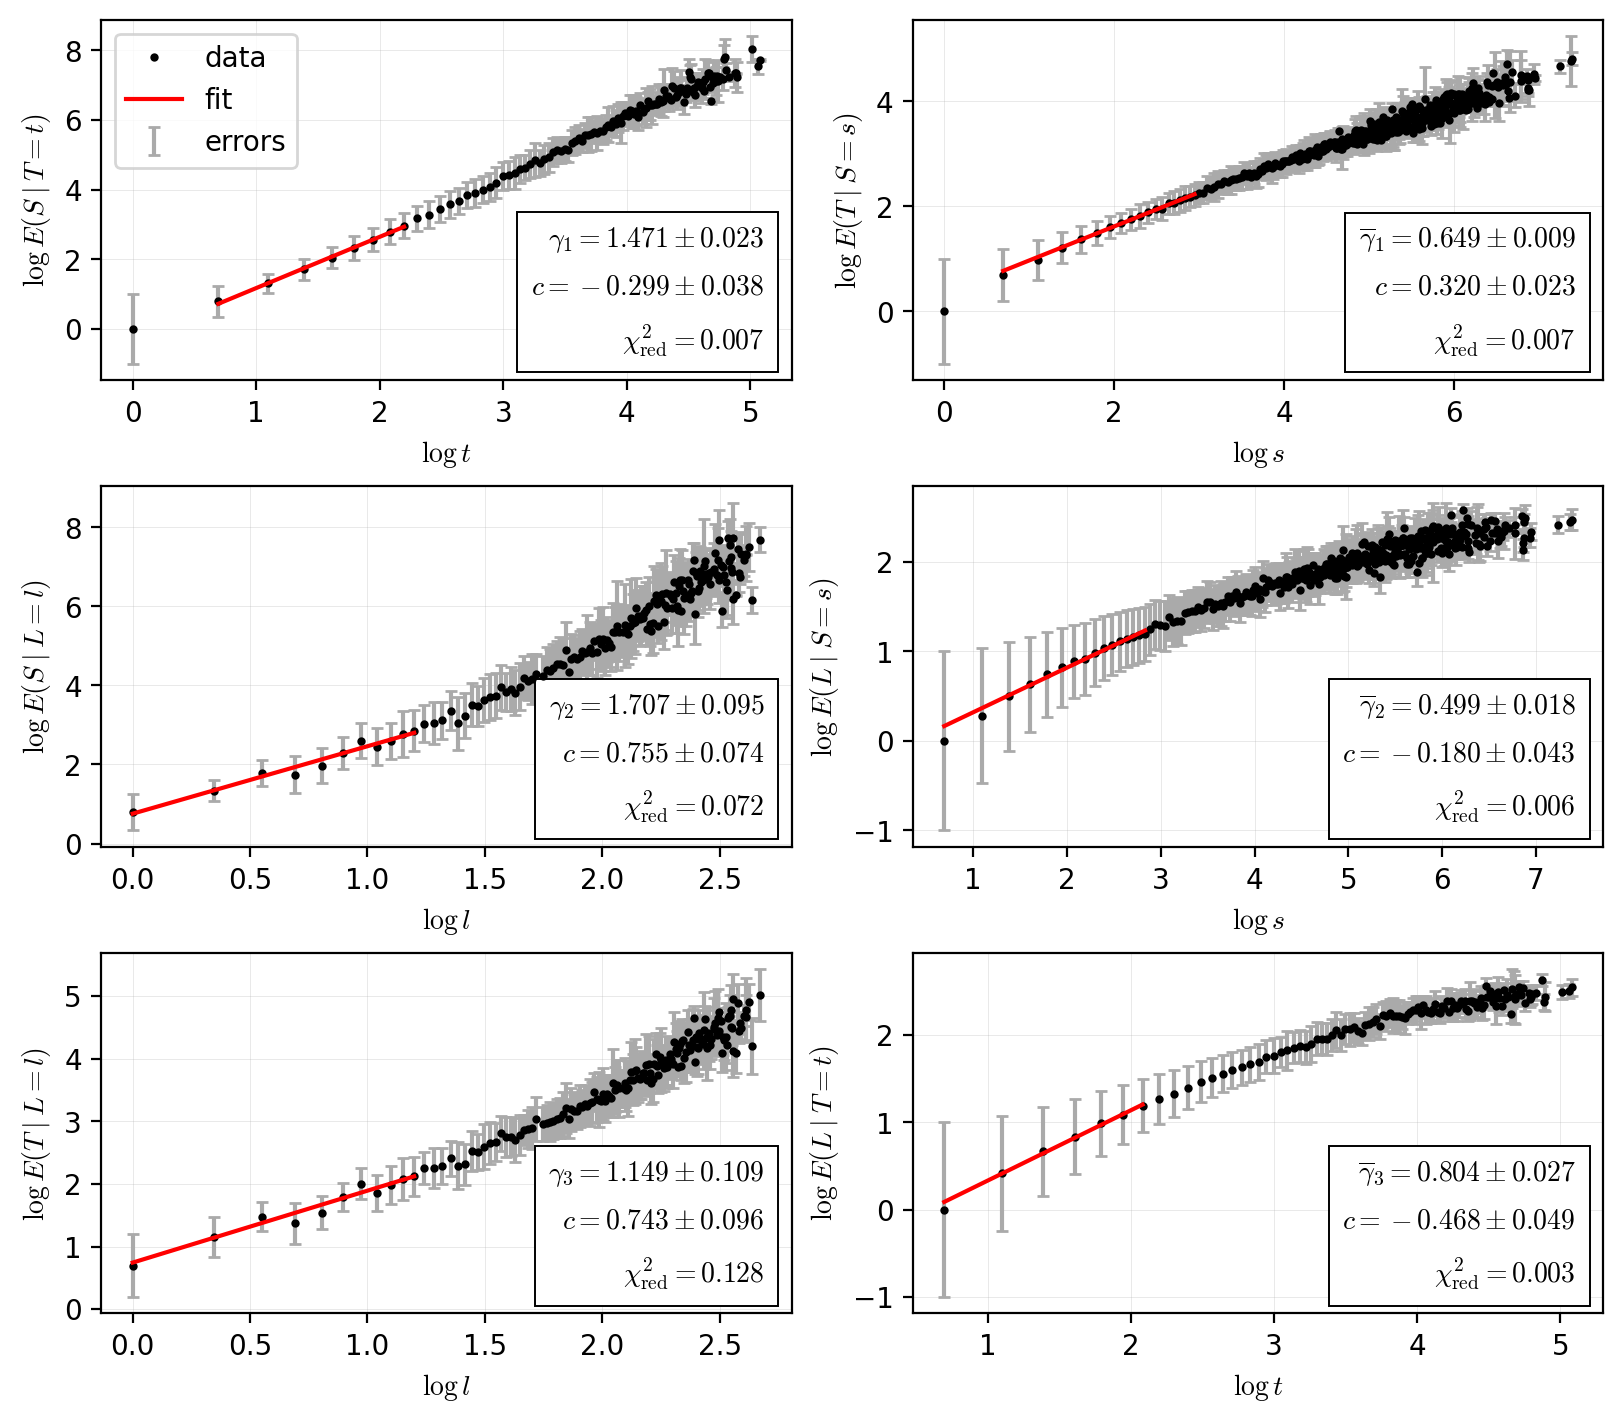

(array([1.4707586 , 0.64905427, 1.70669825, 0.49907445, 1.1486789 ,
        0.80391829]),
 array([0.02297086, 0.00940157, 0.09516262, 0.01781086, 0.10894757,
        0.02709471]))

In [17]:
analyze_cond_exponents(d=4, N=10)

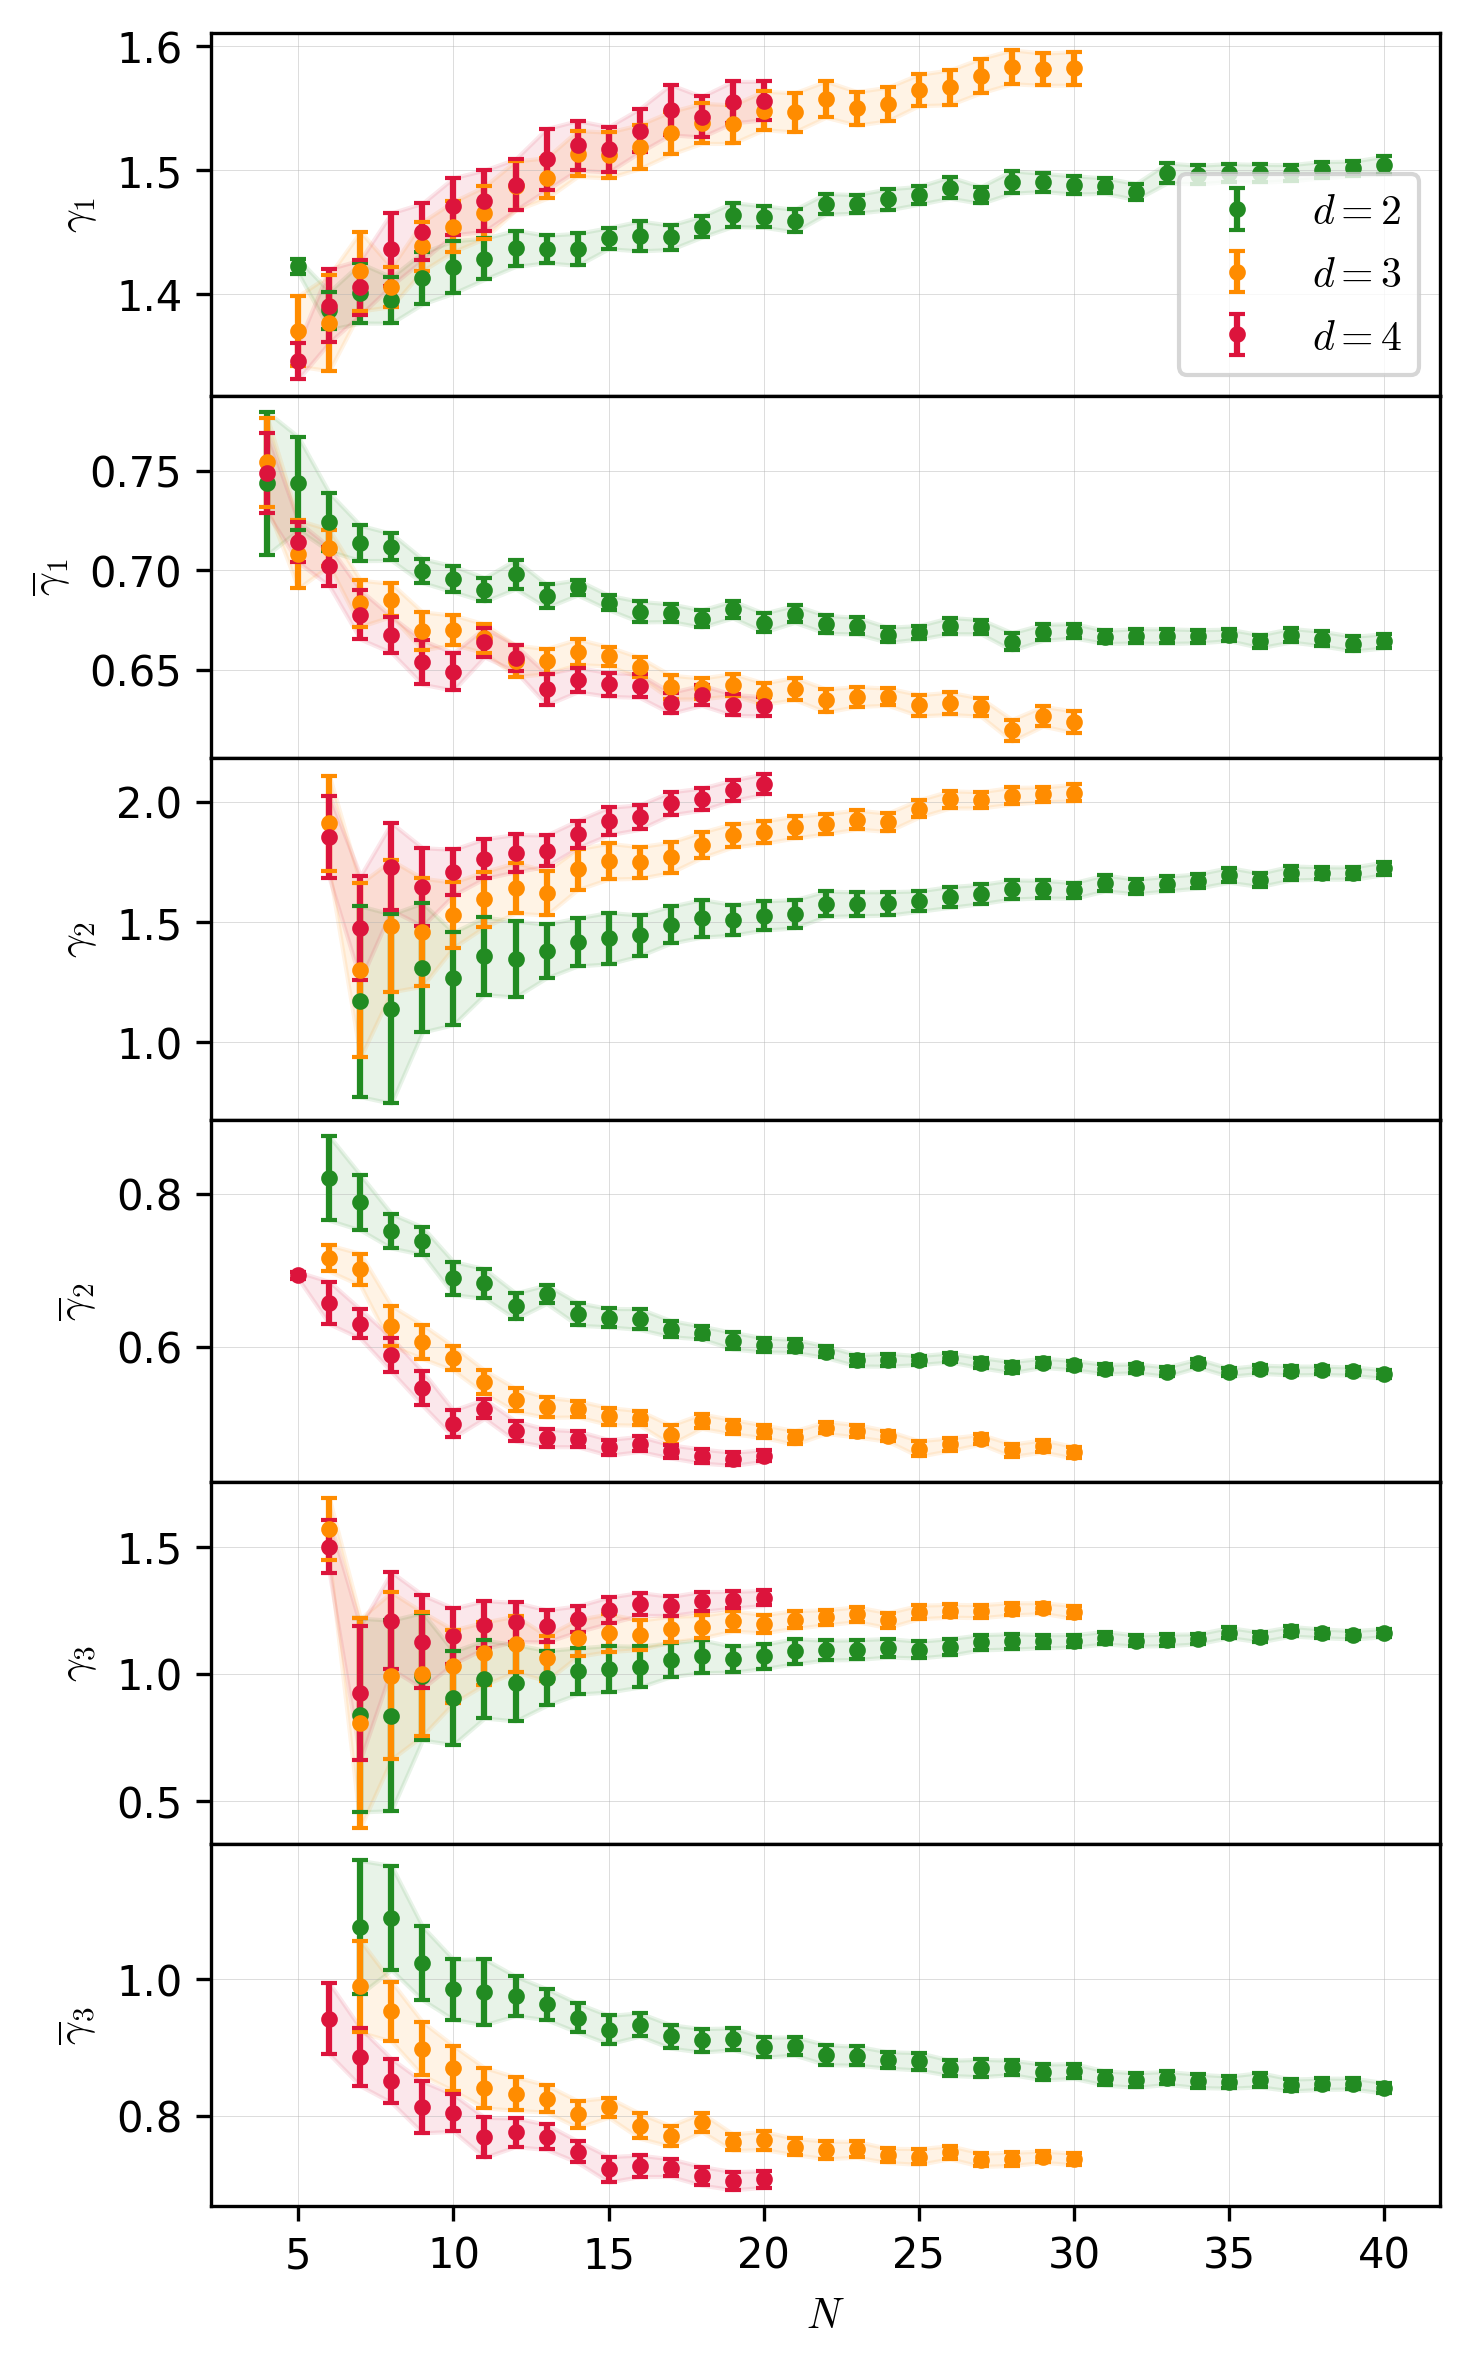

In [18]:
def analyze_cond_exponents_for_all_N(d):
    data = []

    for N in get_avalanche_N_vals(d):
        try:
            cond_exp_vals, cond_exp_errs = analyze_cond_exponents(d=d, N=N, plot=False)
        except Exception as e:
            raise Exception(f"Could not determine exponents for d={d}, N={N}") from e

        row = {"N": N}

        for cond_exp, val, err in zip(cond_exponents.values(), cond_exp_vals, cond_exp_errs):
            row[cond_exp] = val
            row[cond_exp + "_err"] = err
        
        data.append(row)

    return pd.DataFrame(data).sort_values("N")


# This plots each exponent in a seperate plot
def compare_grid_sizes_for_cond_exp():
    fig, axs = plt.subplots(len(cond_exponents), 1, figsize=(5, 8), sharex=True)

    d_vals = [2, 3, 4]
    cond_exp_dfs = [analyze_cond_exponents_for_all_N(d) for d in d_vals] 

    for (cond_exp, cond_exp_symbol), ax in zip(cond_exponent_symbols.items(), axs):
        for d, cond_exp_df in zip(d_vals, cond_exp_dfs):
            N_vals = cond_exp_df["N"]
            e_vals = cond_exp_df[cond_exp]
            e_errs = cond_exp_df[cond_exp + "_err"]

            color = d_colors[d]
            ax.errorbar(N_vals, e_vals, yerr=e_errs, fmt=".", c=color, capsize=2, label=f"$d = {d}$")
            ax.fill_between(N_vals, e_vals - e_errs, e_vals + e_errs, color=color, alpha=.1)            

        ax.set_ylabel(f"${cond_exp_symbol}$")

    axs[-1].set_xlabel("$N$")

    axs[0].legend(loc="lower right")

    plt.tight_layout()
    plt.subplots_adjust(hspace=0)
    plt.savefig("Report/figs/cond_exp_compare_grid_sizes.png", bbox_inches="tight")

compare_grid_sizes_for_cond_exp()

## Relation check

In [19]:
def generate_analysis_results():
    """Generates all analysis results for the scaling exponents and saves them to disk."""

    analysis_dfs = [
        analyze_scaling_exponents_for_all_N(d) \
            .merge(analyze_cond_exponents_for_all_N(d), on="N")
        for d in d_vals
    ]
    for d, df in zip(d_vals, analysis_dfs):
        df.to_feather(f"analysis_results/d{d}.feather")

generate_analysis_results()

FileNotFoundError: [Errno 2] No such file or directory: 'analysis_results/d2.feather'

In [ ]:
def load_analysis_results():
    return [pd.read_feather(f"analysis_results/d{d}.feather") for d in d_vals]

analysis_dfs = load_analysis_results()

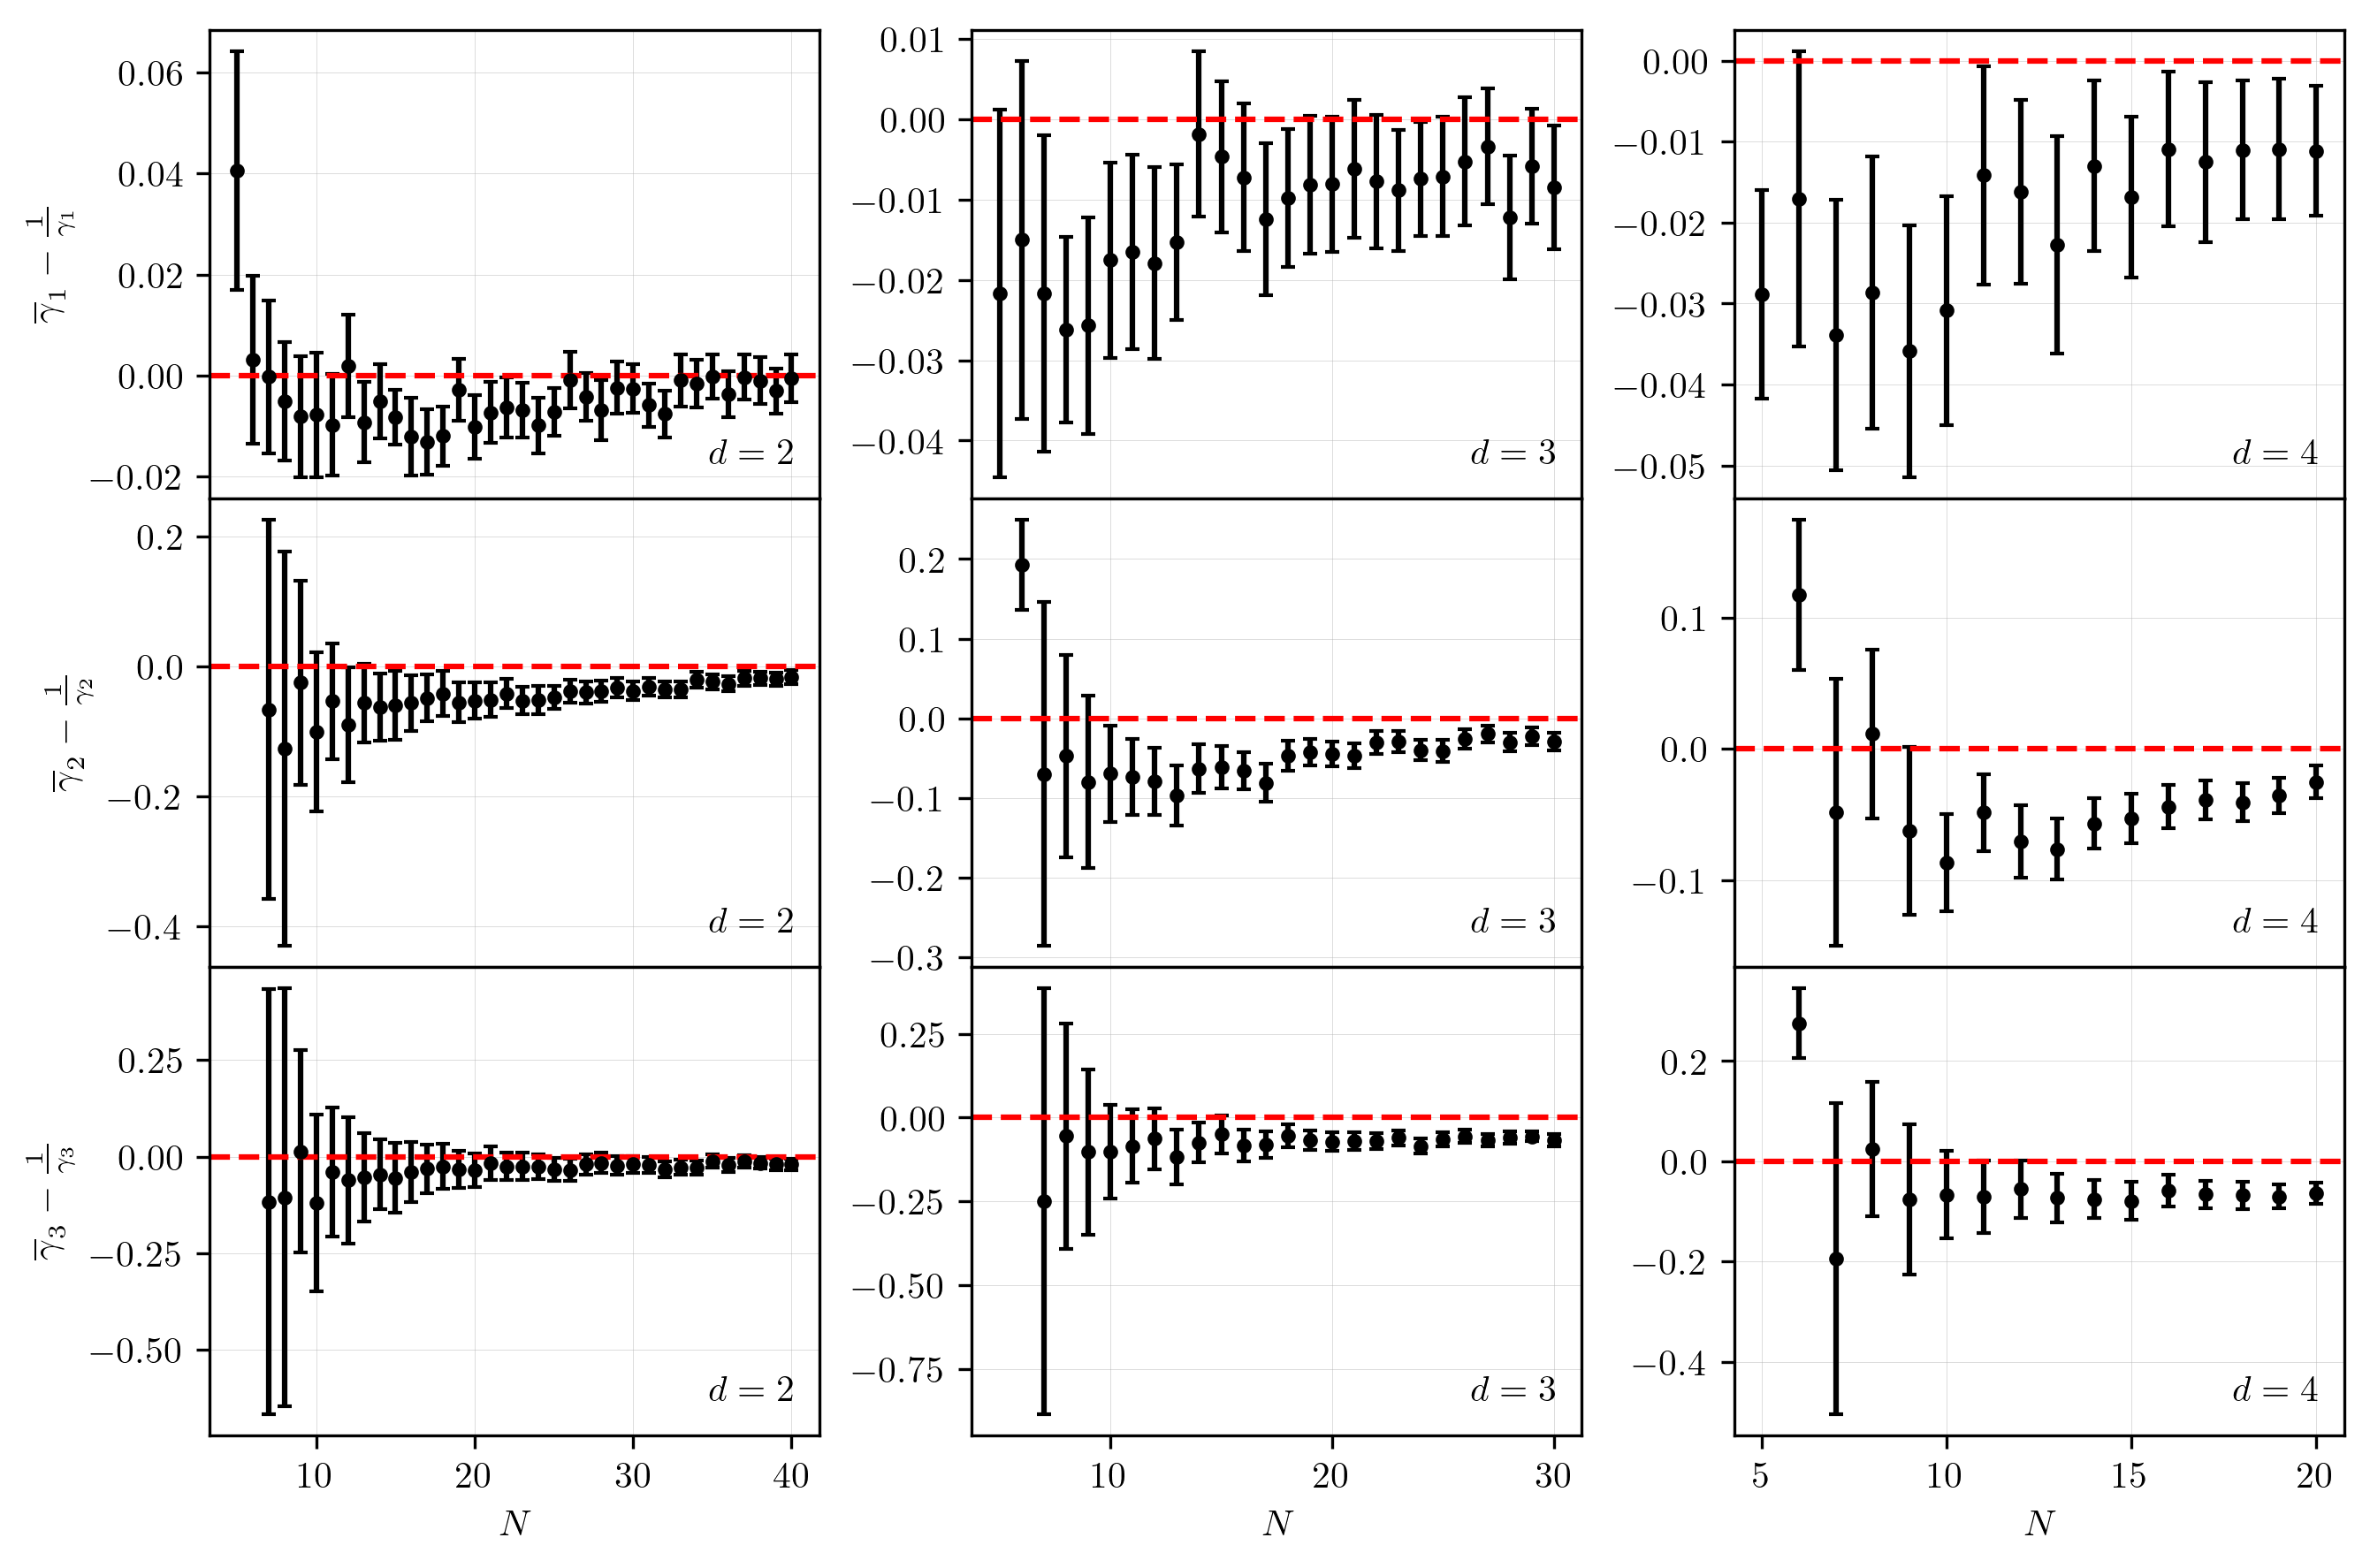

In [ ]:
def check_inverse_cond_exp(cond_exp_dfs):
    exponents = ["gamma_1", "gamma_2", "gamma_3"]
    fig, axs = plt.subplots(len(exponents), len(d_vals), figsize=(9, 6), sharex='col')

    # color1 = "forestgreen"
    # color2 = "slateblue"

    for i, exp in enumerate(exponents):
        exp_symbol = cond_exponent_symbols[exp]
        for j, (d, cond_exp_df) in enumerate(zip(d_vals, cond_exp_dfs)):
            N_vals = cond_exp_df["N"]
            e_vals = cond_exp_df[exp]
            e_errs = cond_exp_df[exp + "_err"]
            e_inv_vals = cond_exp_df[exp + "_inv"]
            e_inv_errs = cond_exp_df[exp + "_inv_err"]

            e1_vals = e_inv_vals
            e1_errs = e_inv_errs
            e2_vals = 1 / e_vals
            e2_errs = e_errs / e_vals**2

            diff_vals = e1_vals - e2_vals
            diff_errs = np.sqrt(e1_errs**2 + e2_errs**2)

            ax = axs[i, j]
            ax.errorbar(N_vals, diff_vals, yerr=diff_errs, fmt=".k", capsize=2)

            ax.axhline(0, c="r", ls="--")


            ax.text(.96, .06, f"$d = {d}$", transform=ax.transAxes, va="bottom", ha="right")
            
            if i == len(scaling_exponent_symbols) - 1:
                ax.set_xlabel("$N$")

            if j == 0:
                ax.set_ylabel(f"$\\overline {exp_symbol} - \\frac{{1}}{{{exp_symbol} }}$")

    plt.tight_layout()
    plt.subplots_adjust(hspace=0, wspace=.25)
    plt.savefig("Report/figs/inverse_cond_exponents.png", bbox_inches="tight")

check_inverse_cond_exp(analysis_dfs)

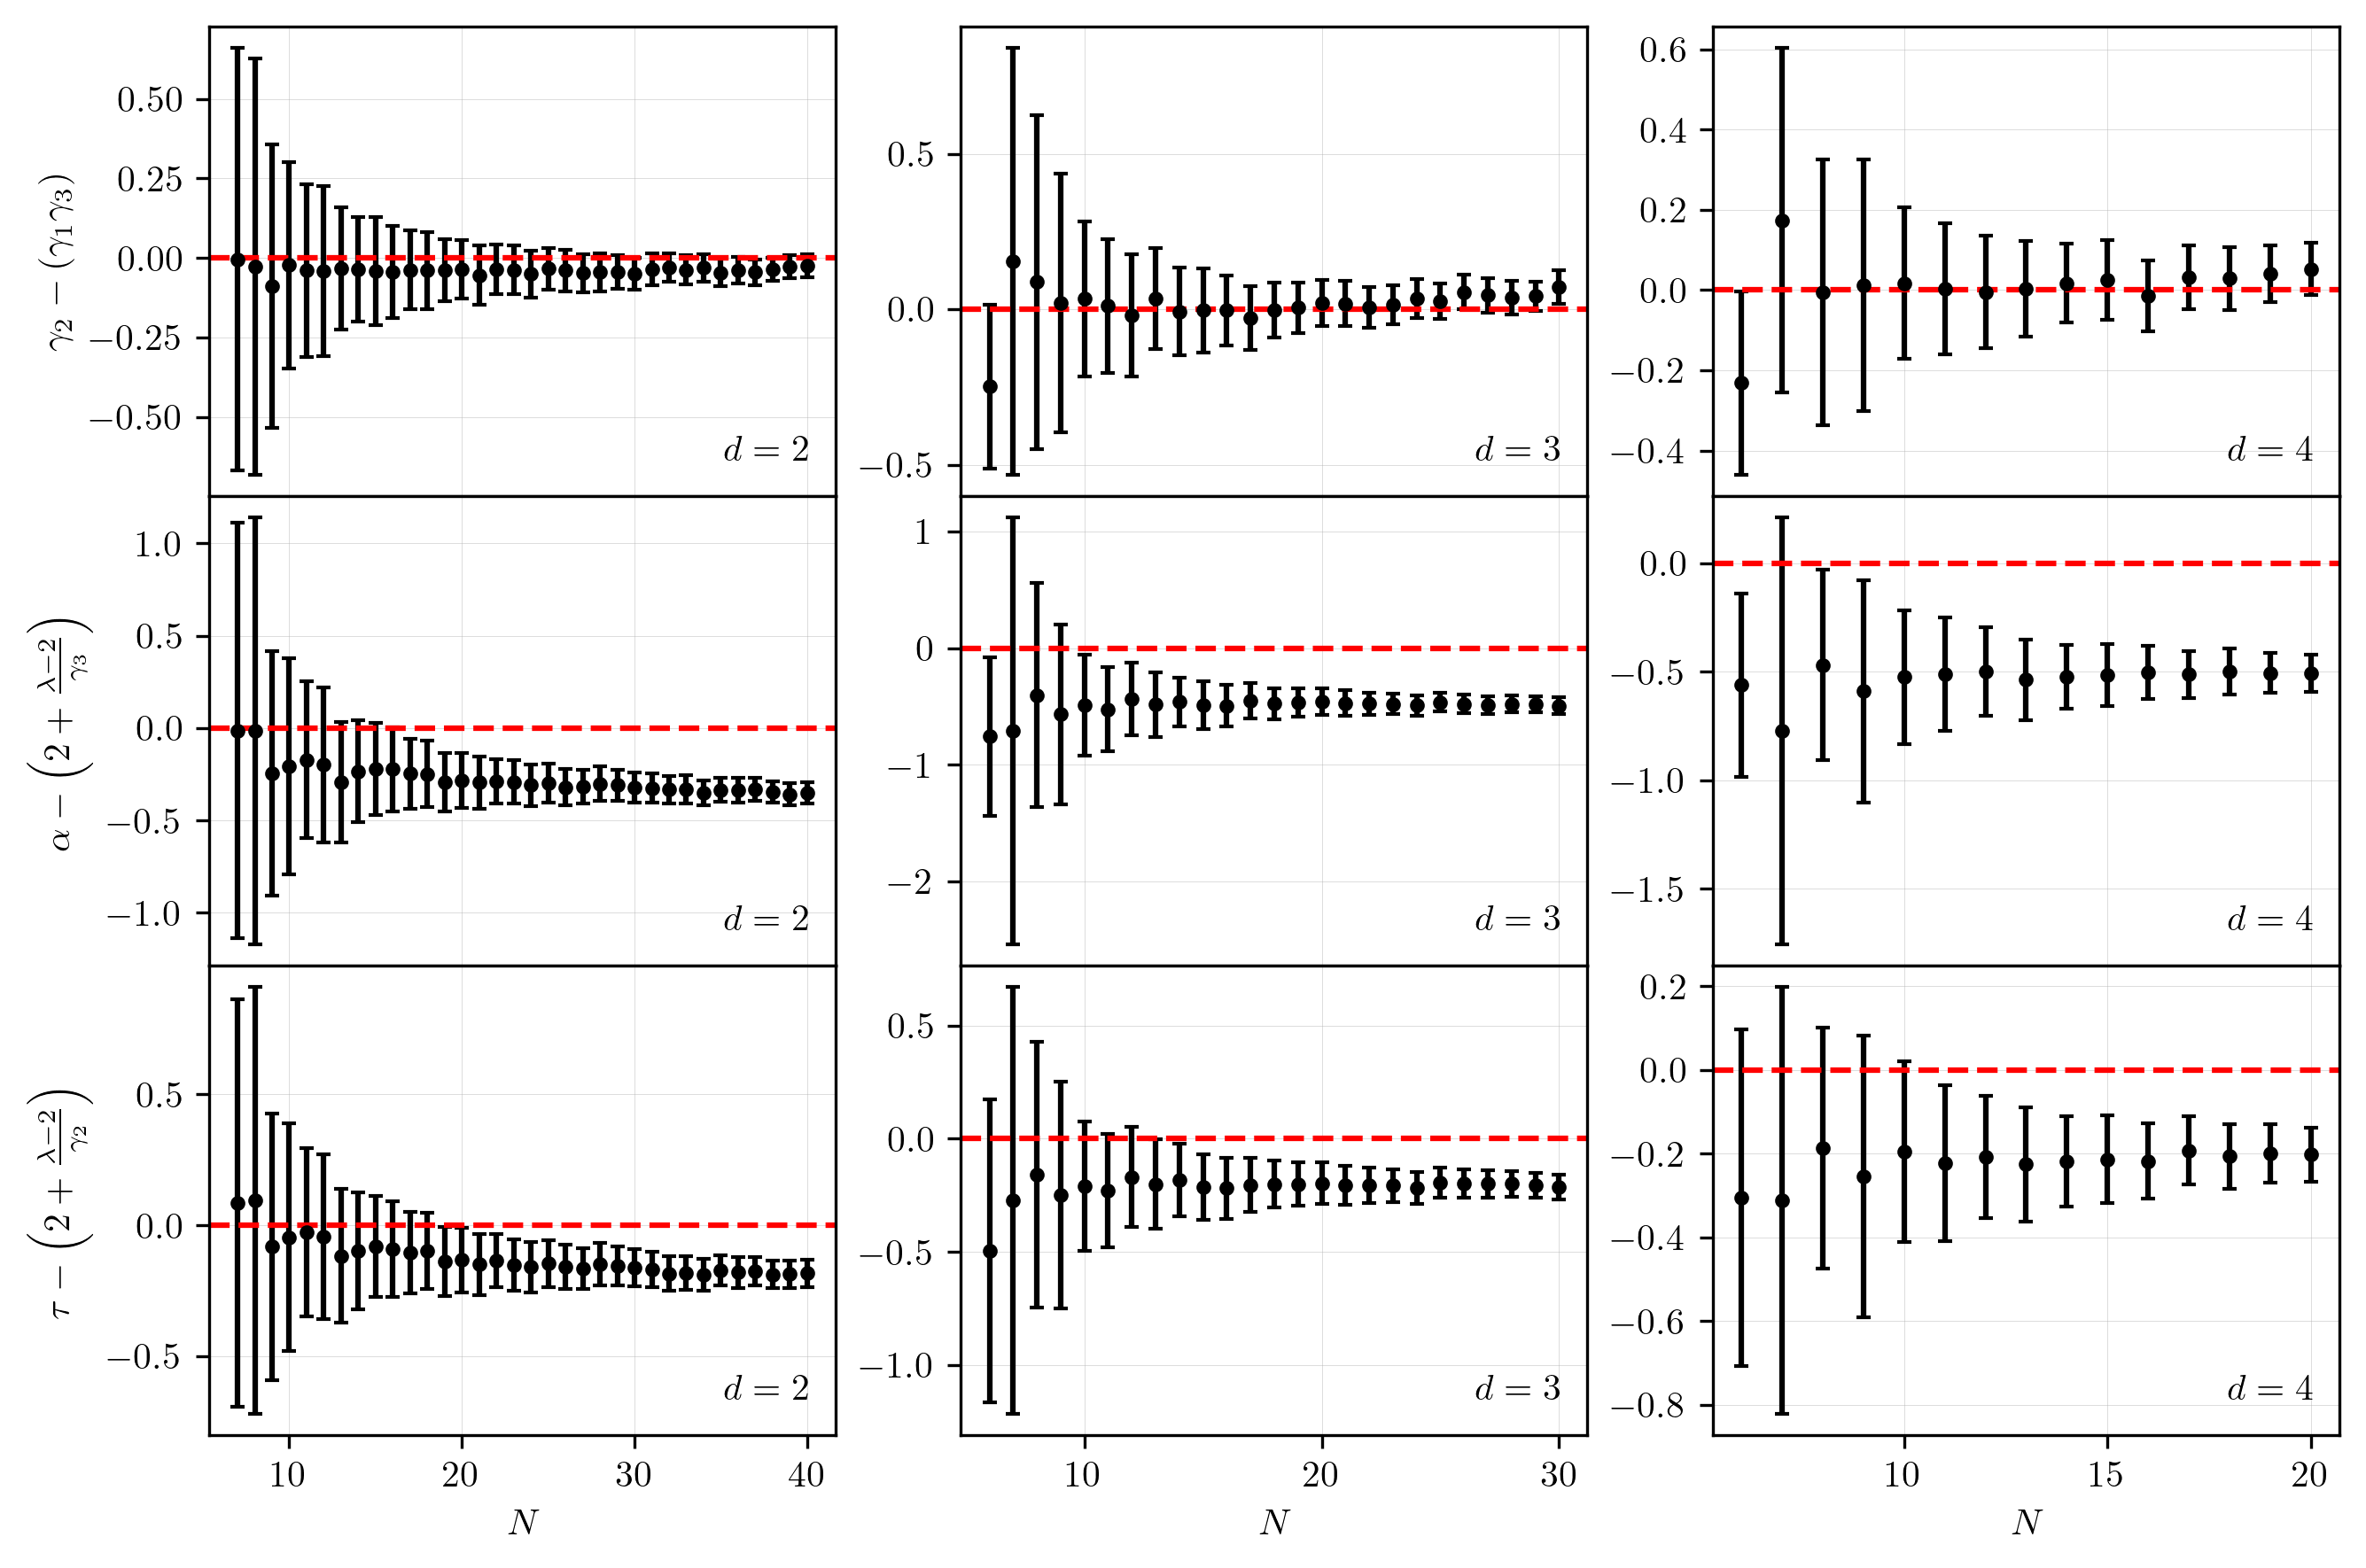

In [ ]:
def check_scaling_exp_relations(dfs):
    fig, axs = plt.subplots(len(scaling_exponent_symbols), len(d_vals), figsize=(9, 6), sharex="col")

    relation_exprs = [
        ("\\gamma_2", "\\gamma_1 \\gamma_3"),
        ("\\alpha", "2 + \\frac{\\lambda - 2}{\\gamma_3}"),
        ("\\tau", "2 + \\frac{\\lambda - 2}{\\gamma_2}"),
    ]


    relation_funcs = [
        lambda df: (df["gamma_2"], df["gamma_1"] * df["gamma_3"]),
        lambda df: (df["alpha"], 2 + (df["lambda"] - 2) / df["gamma_3"]),
        lambda df: (df["tau"], 2 + (df["lambda"] - 2) / df["gamma_2"]),
    ]

    relation_err_funcs = [
        lambda df: (
            df["gamma_2_err"].values, 
            np.sqrt(
                (df["gamma_1"].values * df["gamma_3_err"].values)**2
                + (df["gamma_1_err"].values * df["gamma_3"].values)**2
            ),
        ),
        lambda df: (
            df["alpha_err"].values,
            np.sqrt(
                (df["lambda_err"].values / df["gamma_3"].values)**2
                + (df["lambda"].values * df["gamma_3_err"].values / df["gamma_3"].values**2)**2
            ),
        ),
        lambda df: (
            df["tau_err"].values,
            np.sqrt(
                (df["lambda_err"].values / df["gamma_3"].values)**2
                + (df["lambda"].values * df["gamma_3_err"].values / df["gamma_2"].values**2)**2
            ),
        )
    ]

    for i, relation_func in enumerate(relation_funcs):
        lhs_expr, rhs_expr = relation_exprs[i]
        relation_err_func = relation_err_funcs[i]

        for j, (d, df) in enumerate(zip(d_vals, dfs)):
            N_vals = df["N"]
            lhs_vals, rhs_vals = relation_func(df)
            lhs_errs, rhs_errs = relation_err_func(df)

            diff_vals = lhs_vals - rhs_vals
            diff_errs = np.sqrt(lhs_errs**2 + rhs_errs**2)

            ax = axs[i, j]
            ax.errorbar(N_vals, diff_vals, yerr=diff_errs, fmt=".k", capsize=2)

            ax.axhline(0, c="r", ls="--")


            ax.text(.96, .06, f"$d = {d}$", transform=ax.transAxes, va="bottom", ha="right")
            
            if i == len(scaling_exponent_symbols) - 1:
                ax.set_xlabel("$N$")

            if j == 0:
                ax.set_ylabel(f"${lhs_expr} - \\left( {rhs_expr} \\right)$")

    plt.tight_layout()
    plt.subplots_adjust(hspace=0, wspace=.2)
    plt.savefig("Report/figs/scaling_exp_relations.png", bbox_inches="tight")

check_scaling_exp_relations(analysis_dfs)

In [ ]:
def format_errval(val, err):
    return f"${val:.3f} \\pm {err:.3f}$"

def create_scaling_exp_table():
    rows = []

    d_N_configs = [(2, 20), (2, 30), (2, 40), (3, 20), (3, 30), (4, 10), (4, 20)]

    for d, N in d_N_configs:
        df = analysis_dfs[d_vals.index(d)].query("N == @N")
        if df.empty:
            print(f"Warning: no data for d = {d}, N = {N}")
            continue

        df_row = df.iloc[0]

        row = {
            "$d$": d,
            "$N$": N,
            "$\\alpha$": format_errval(df_row["alpha"], df_row["alpha_err"]),
            "$\\tau$": format_errval(df_row["tau"], df_row["tau_err"]),
            "$\\lambda$": format_errval(df_row["lambda"], df_row["lambda_err"]),
        }

        rows.append(row)

    pd.DataFrame(rows).to_latex("Report/tables/scaling_exp_table.tex", escape=False, index=False)

create_scaling_exp_table()

In [ ]:
def create_cond_exp_table():
    rows = []

    d_N_configs = [(2, 20), (2, 30), (2, 40), (3, 20), (3, 30), (4, 10), (4, 20)]

    for d, N in d_N_configs:
        df = analysis_dfs[d_vals.index(d)].query("N == @N")
        if df.empty:
            print(f"Warning: no data for d = {d}, N = {N}")
            continue

        df_row = df.iloc[0]

        row = {
            "$d$": d,
            "$N$": N,
        }
        for i in range(1, 4):
            row[f"$\\gamma_{i}$"] = format_errval(df_row[f"gamma_{i}"], df_row[f"gamma_{i}_err"])

            
        rows.append(row)

    pd.DataFrame(rows).to_latex("Report/tables/cond_exp_table.tex", escape=False, index=False)

create_cond_exp_table()

In [ ]:
def create_inv_cond_exp_table():
    rows = []

    d_N_configs = [(2, 20), (2, 30), (2, 40), (3, 20), (3, 30), (4, 10), (4, 20)]

    for d, N in d_N_configs:
        df = analysis_dfs[d_vals.index(d)].query("N == @N")
        if df.empty:
            print(f"Warning: no data for d = {d}, N = {N}")
            continue

        df_row = df.iloc[0]

        row = {
            "$d$": d,
            "$N$": N,
        }
        for i in range(1, 4):
            row[f"$\\overline \\gamma_{i}$"] = format_errval(df_row[f"gamma_{i}_inv"], df_row[f"gamma_{i}_inv_err"])

            
        rows.append(row)

    pd.DataFrame(rows).to_latex("Report/tables/inv_cond_exp_table.tex", escape=False, index=False)

create_inv_cond_exp_table()

## Autocorrelation

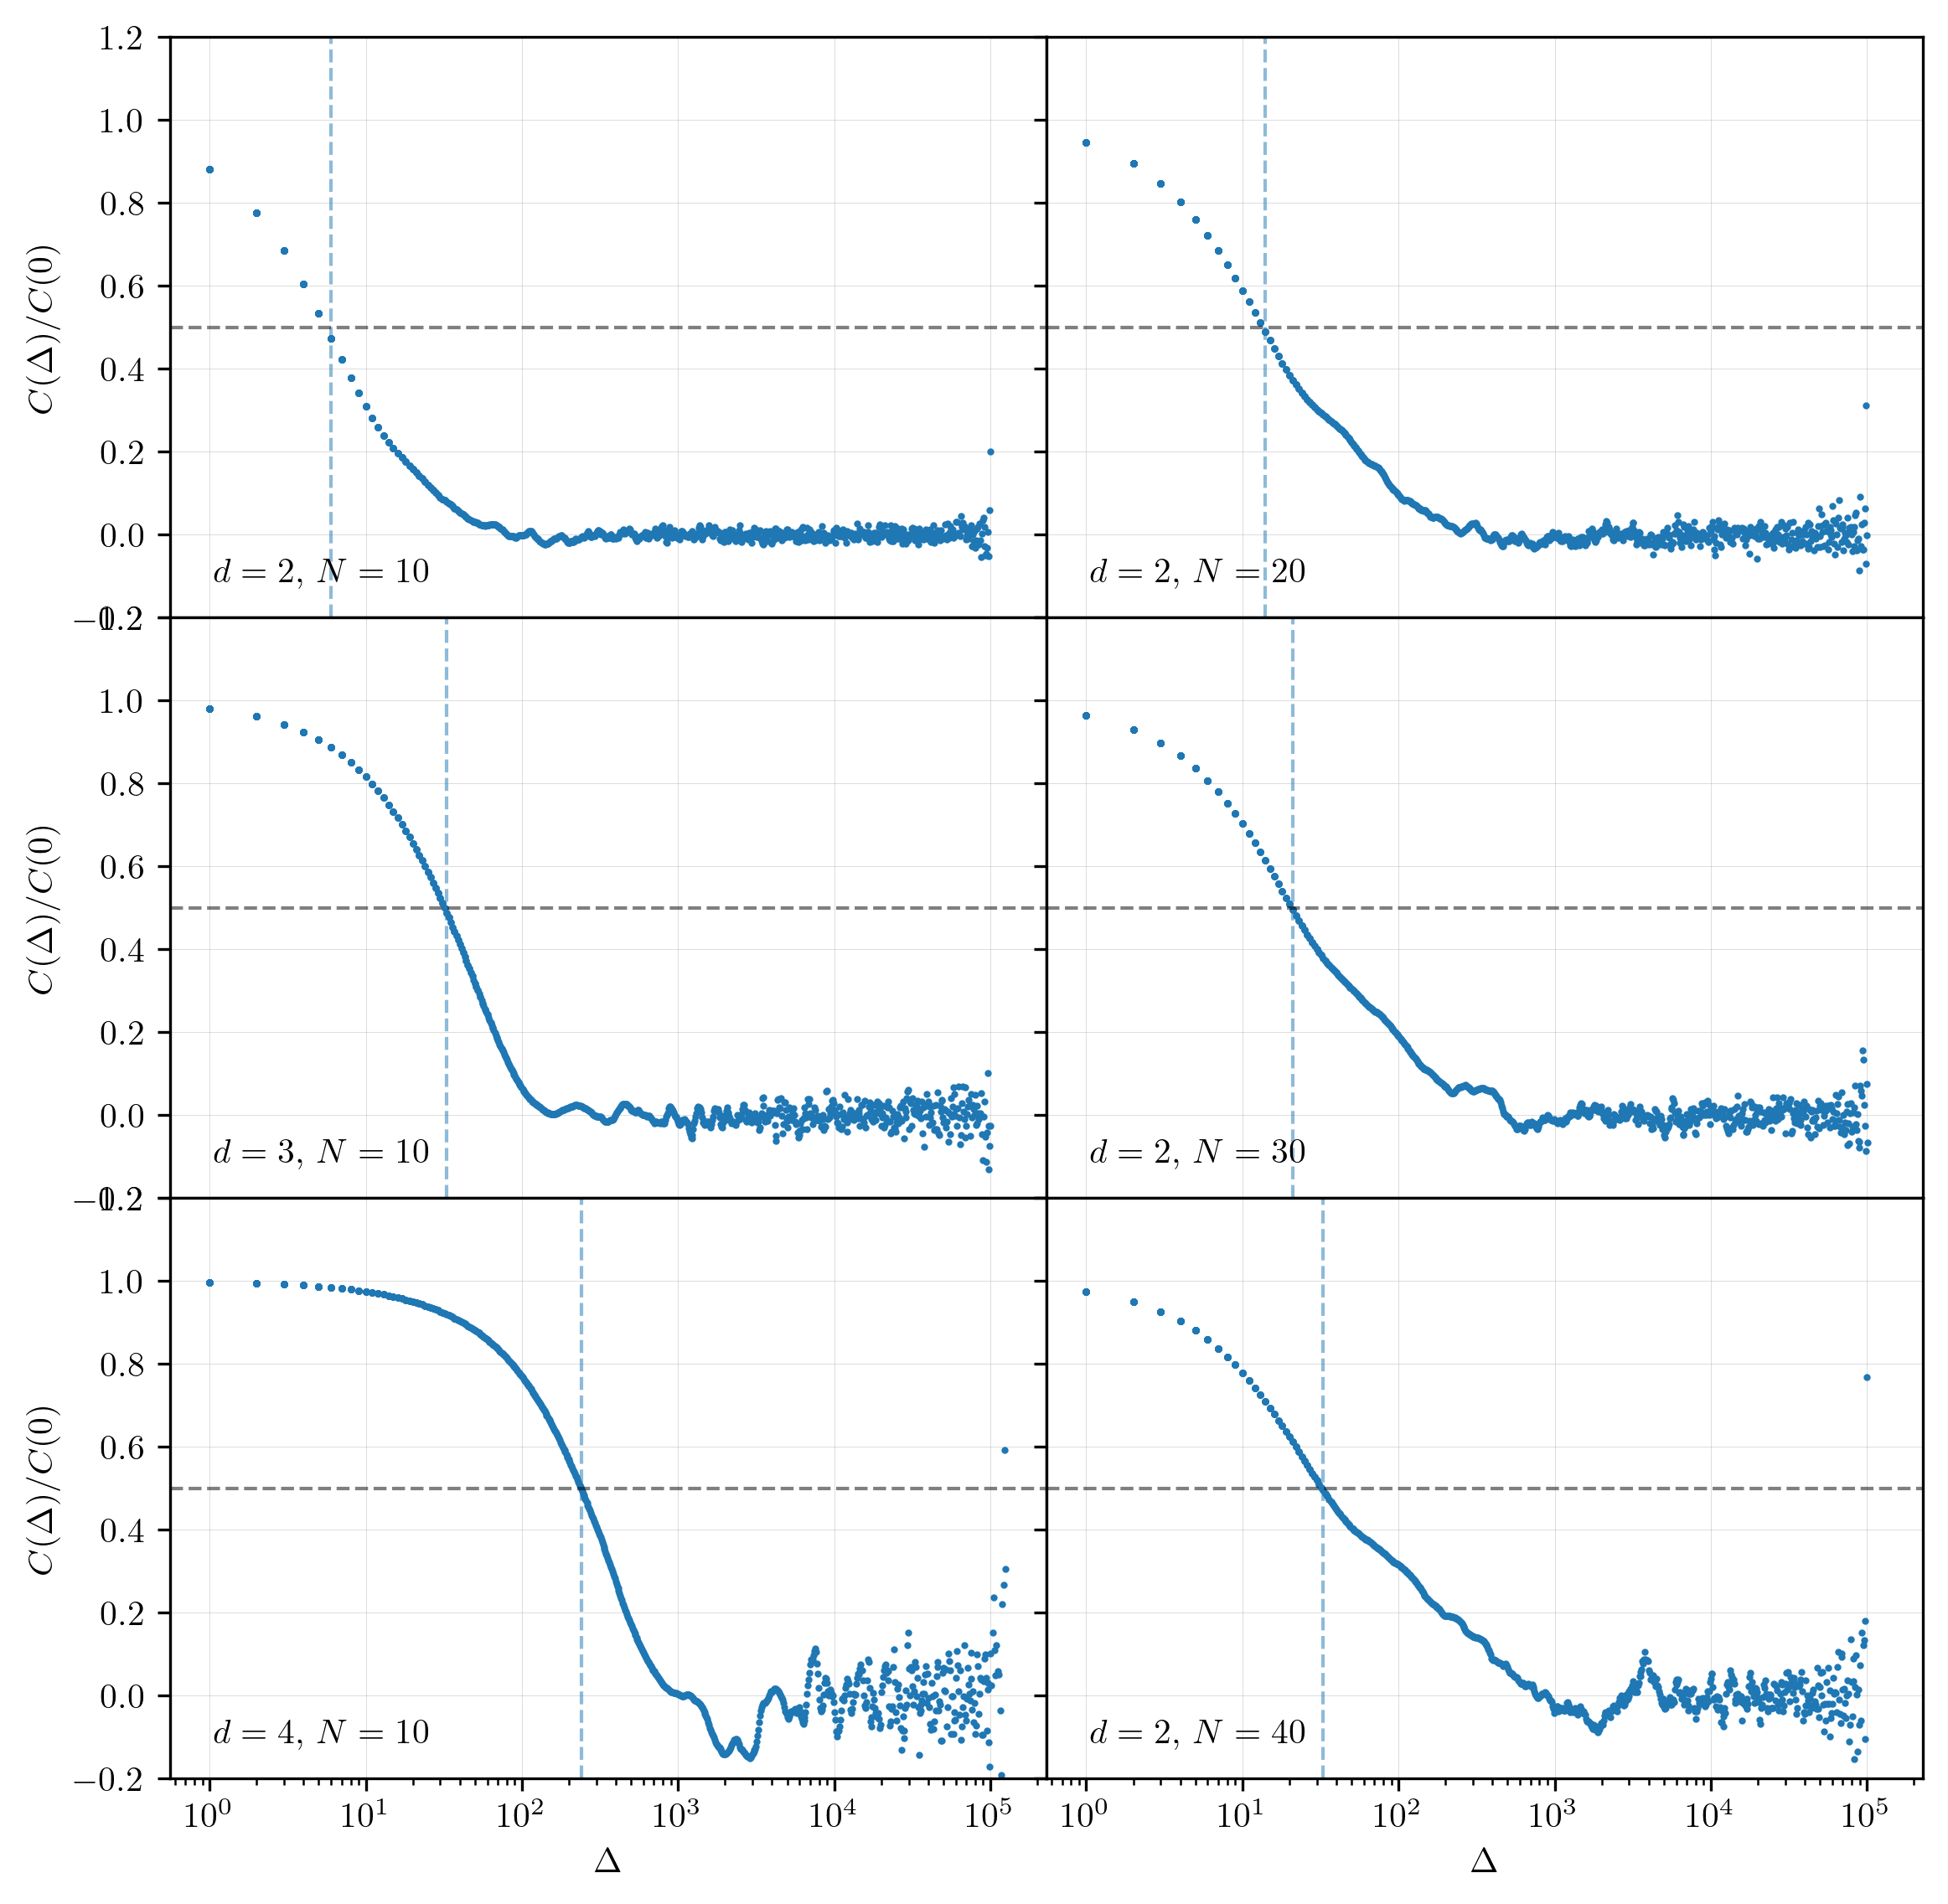

In [ ]:
def get_autocorr_trans(z_avg):
    mean = np.mean(z_avg)
    C0 = np.mean((z_avg - mean)**2)
    
    # Rough steps
    rough_step = 10
    for rough_delta in np.arange(1, len(z_avg), rough_step):
        autocorr = np.mean(
            (z_avg[:-rough_delta] - mean) * (z_avg[rough_delta:] - mean)
        )

        if abs(autocorr) < .5 * C0:
            # Fine steps
            for delta in np.arange(rough_delta - rough_step, len(z_avg)):
                autocorr = np.mean(
                    (z_avg[:-delta] - mean) * (z_avg[delta:] - mean)
                )

                if autocorr < .5 * C0:
                    return delta

    return np.nan

def analyze_autocorr():
    d_N_configs = np.array([
        (2, 10), (2, 20),
        (3, 10), (2, 30),
        (4, 10), (2, 40),
    ])

    fig, axs = plt.subplots(3, 2, figsize=(9, 9), sharex=True, sharey=True)
    axs = axs.flatten()
    
    for i, ax in enumerate(axs):
        d, N = d_N_configs[i]

        avalanches_df = load_avalanches(d, N)
        if avalanches_df is None:
            print(f"Warning: no data for d = {d}, N = {N}")
            continue

        therm_end = get_thermalization_end(avalanches_df) + 100
        avalanches_df = avalanches_df.iloc[therm_end:]

        z_avg = avalanches_df["z_avg"].values

        delta_vals = np.logspace(0, np.log10(len(z_avg) - 1), 1000, dtype=int)
        autocorr_vals = []

        mean = np.mean(z_avg)
        
        for delta in delta_vals:
            autocorr = np.mean(
                (z_avg[:-delta] - mean) * (z_avg[delta:] - mean)
            )

            autocorr_vals.append(autocorr)

        autocorr_vals = np.array(autocorr_vals)

        C0 = np.mean((z_avg - mean)**2)
        autocorr_vals /= C0

        p, = ax.plot(delta_vals, autocorr_vals, '.', ms=2)

        trans = get_autocorr_trans(z_avg)
        if not np.isnan(trans):
            ax.axvline(trans, ls='--', lw=1, c=p.get_color(), alpha=0.5)

        ax.axhline(0.5, ls='--', lw=1, c='k', alpha=0.5)

        ax.text(0.05, 0.05, f"$d = {d}$, $N = {N}$", transform=ax.transAxes, ha="left", va="bottom")

        ax.set_xscale("log")

        ax.set_ylim(-.2, 1.2)

        if i in [4, 5]:
            ax.set_xlabel("$\\Delta$")
        if i in [0, 2, 4]:
            ax.set_ylabel("$C(\\Delta) / C(0)$")

    plt.subplots_adjust(wspace=0, hspace=0)

    plt.savefig("Report/figs/autocorr.png", bbox_inches="tight")
    plt.show()
    
analyze_autocorr()

100%|██████████| 17/17 [00:18<00:00,  1.11s/it]


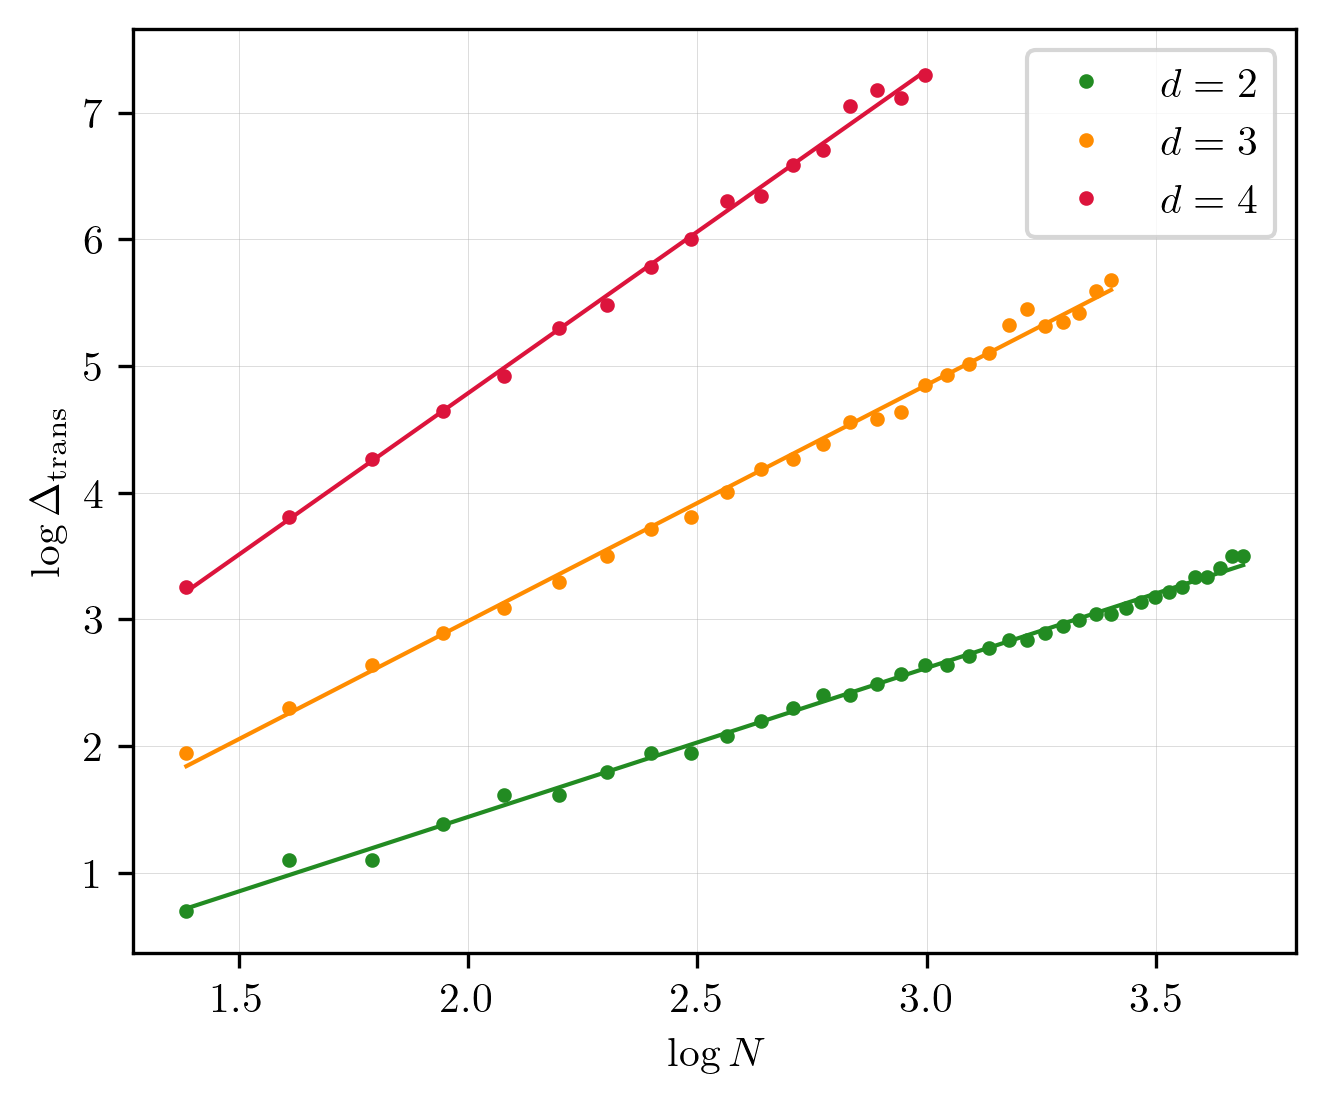

In [ ]:
def analyze_autocorr_trans():
    fig, ax = plt.subplots(figsize=(5, 4))

    results = []
    
    for d in d_vals:
        dfs, N_vals = load_all_avalanches(d)
        trans_vals = []

        for df in tqdm(dfs):
            therm_end = get_thermalization_end(df) + 100
            df = df.iloc[therm_end:]

            z_avg = df["z_avg"].values

            
            trans = get_autocorr_trans(z_avg)

            trans_vals.append(trans)

        log_N = np.log(N_vals)
        log_trans = np.log(trans_vals)

        color = d_colors[d]
        ax.plot(log_N, log_trans, '.', ms=5, c=color, label=f"$d = {d}$")

        model = lmfit.models.LinearModel()
        result = model.fit(log_trans, x=log_N)
        results.append(result)

        ax.plot(log_N, result.best_fit, c=color, lw=1)


    ax.set_xlabel("$\\log N$")
    ax.set_ylabel("$\\log \\Delta_\\mathrm{trans}$")
    ax.legend()
    plt.savefig("Report/figs/autocorr_trans.png", bbox_inches="tight")
    plt.show()

    return results
    
autocorr_trans_results = analyze_autocorr_trans()

In [ ]:
for d, result in zip(d_vals, autocorr_trans_results):
    print(f"d = {d}")
    print(result.fit_report())

d = 2
[[Model]]
    Model(linear)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 6
    # data points      = 37
    # variables        = 2
    chi-square         = 0.07070247
    reduced chi-square = 0.00202007
    Akaike info crit   = -227.627129
    Bayesian info crit = -224.405293
[[Variables]]
    slope:      1.17756161 +/- 0.01201635 (1.02%) (init = 1)
    intercept: -0.91649921 +/- 0.03601268 (3.93%) (init = 0)
[[Correlations]] (unreported correlations are < 0.100)
    C(slope, intercept) = -0.979
d = 3
[[Model]]
    Model(linear)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 6
    # data points      = 27
    # variables        = 2
    chi-square         = 0.12432002
    reduced chi-square = 0.00497280
    Akaike info crit   = -141.279793
    Bayesian info crit = -138.688119
[[Variables]]
    slope:      1.86658122 +/- 0.02428389 (1.30%) (init = 1)
    intercept: -0.74801228 +/- 0.06692677 (8.95%) (init = 0)
[[Correlatio

## Statistical properties of $\langle z \rangle$

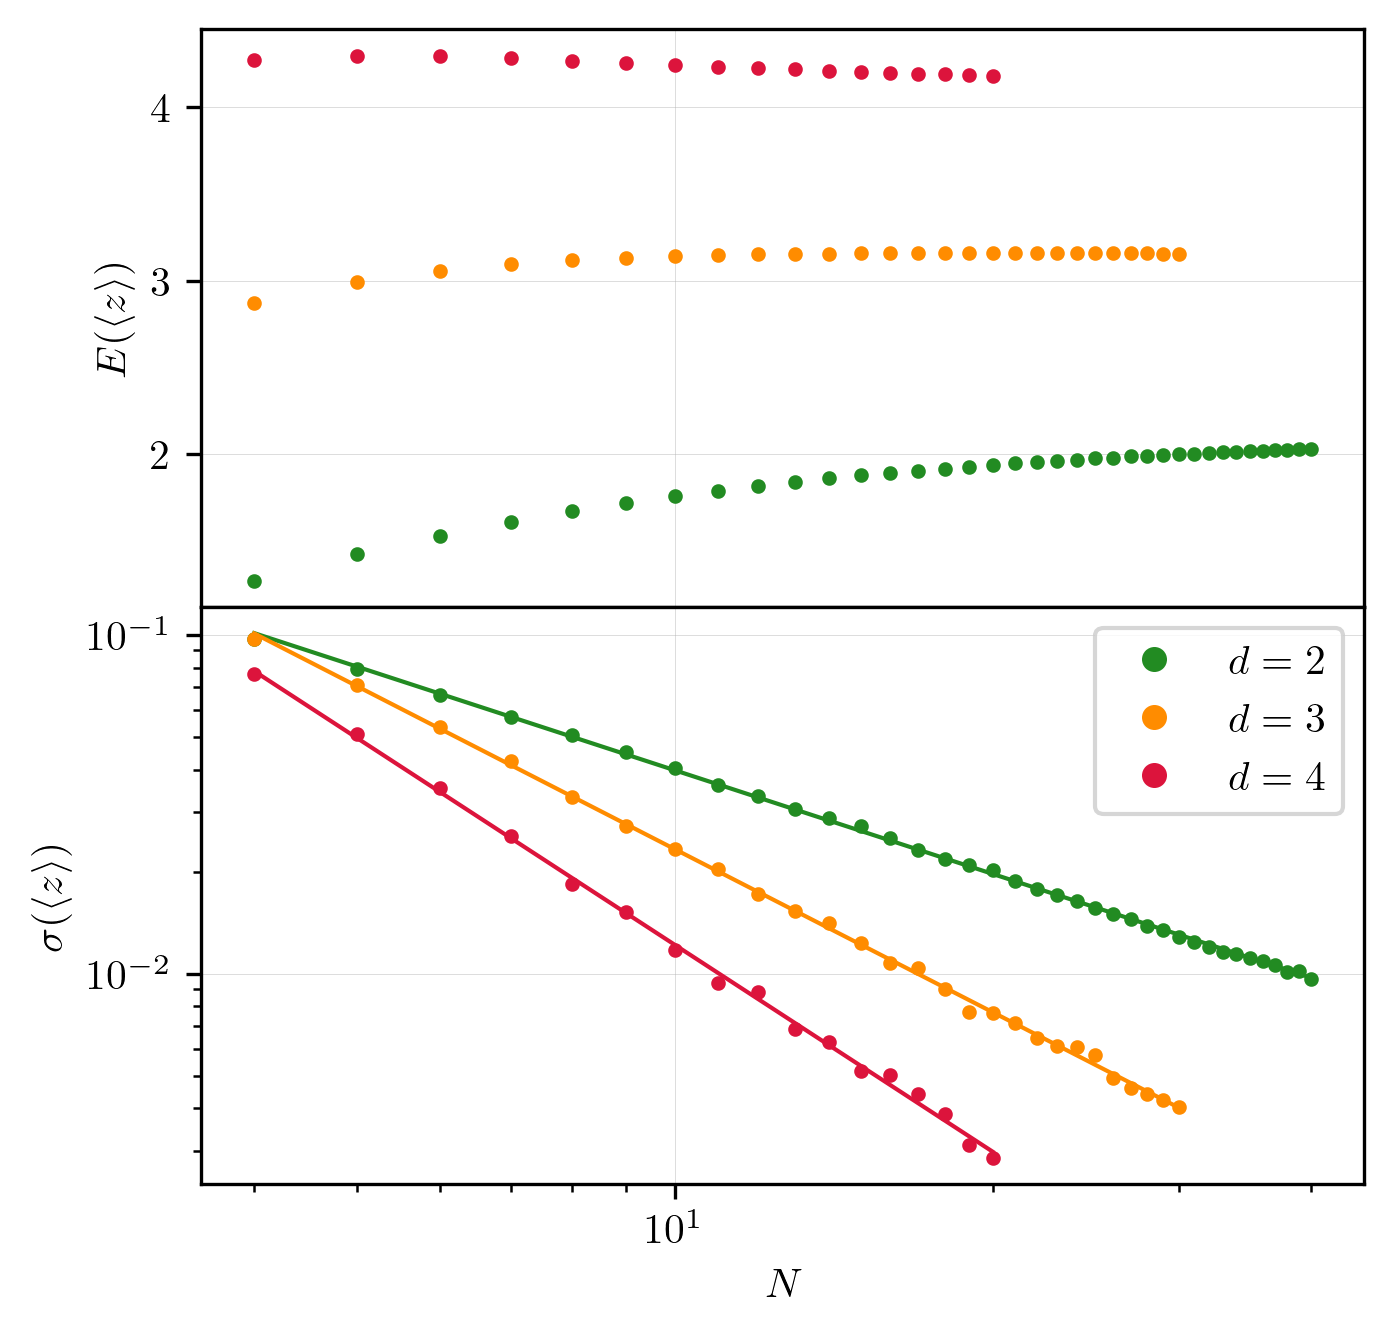

In [ ]:
def analyze_z_avg_stats():
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(5, 5), sharex=True)

    std_fit_results = []

    for d in d_vals:
        dfs, N_vals = load_all_avalanches(d)
        N_vals = np.array(N_vals)

        means = []
        stds = []

        for df, N in zip(dfs, N_vals):
            therm_end = get_thermalization_end(df) + 100
            df = df.iloc[therm_end:]

            z_avg = df["z_avg"].values

            means.append(np.mean(z_avg))
            stds.append(np.std(z_avg))

        color = d_colors[d]
        ax1.plot(N_vals, means, '.', ms=5, c=color, label=f"$d = {d}$")
        ax2.plot(N_vals, stds, '.', ms=5, c=color, label=f"$d = {d}$")

        #ax1.axhline(d, c=color, ls='--', alpha=.5, lw=1)

        model = lmfit.models.LinearModel()
        result = model.fit(np.log(stds), x=np.log(N_vals))
        ax2.plot(N_vals, np.exp(result.best_fit), c=color, lw=1)

        std_fit_results.append(result)

    ax1.set_ylabel("$E(\\langle z \\rangle)$")

    ax2.set_xlabel("$N$")
    ax2.set_ylabel("$\\sigma(\\langle z \\rangle)$")
    ax2.set_xscale("log")
    ax2.set_yscale("log")
    ax2.legend(markerscale=2, loc="upper right")

    plt.subplots_adjust(hspace=0)
    plt.savefig("Report/figs/z_avg_stats.png", bbox_inches="tight")
    plt.show()

    return std_fit_results
            
std_fit_results = analyze_z_avg_stats()

In [ ]:
for d, result in zip(d_vals, std_fit_results):
    print(f"d = {d}:")
    print(result.fit_report())

d = 2:
[[Model]]
    Model(linear)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 7
    # data points      = 37
    # variables        = 2
    chi-square         = 0.00782981
    reduced chi-square = 2.2371e-04
    Akaike info crit   = -309.047194
    Bayesian info crit = -305.825359
[[Variables]]
    slope:     -1.01735178 +/- 0.00399881 (0.39%) (init = 1)
    intercept: -0.88072626 +/- 0.01198433 (1.36%) (init = 0)
[[Correlations]] (unreported correlations are < 0.100)
    C(slope, intercept) = -0.979
d = 3:
[[Model]]
    Model(linear)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 7
    # data points      = 27
    # variables        = 2
    chi-square         = 0.02439261
    reduced chi-square = 9.7570e-04
    Akaike info crit   = -185.251424
    Bayesian info crit = -182.659750
[[Variables]]
    slope:     -1.60016336 +/- 0.01075666 (0.67%) (init = 1)
    intercept: -0.07508136 +/- 0.02964550 (39.48%) (init = 0)
[[Correla